In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Demand File 電力需要.csv

In [2]:
demand_file = '電力需要.csv'

# Load demand file as a dataframe
demand = pd.read_csv(demand_file, parse_dates=[0]) # convert column 0 to datetime64 type
demand.head()

datetime  当日実績(万kW)
0 2021-01-01 00:00:00       1571
1 2021-01-01 01:00:00       1492
2 2021-01-01 02:00:00       1453
3 2021-01-01 03:00:00       1412
4 2021-01-01 04:00:00       1358

In [3]:
# Rename column name 当日実績(万kW) to demand_mankw
demand = demand.rename(columns={"当日実績(万kW)":"demand_mankw"})
demand.head()

datetime  demand_mankw
0 2021-01-01 00:00:00          1571
1 2021-01-01 01:00:00          1492
2 2021-01-01 02:00:00          1453
3 2021-01-01 03:00:00          1412
4 2021-01-01 04:00:00          1358

In [4]:
# check the data types of the columns
demand.dtypes

datetime        datetime64[ns]
demand_mankw             int64
dtype: object

In [5]:
# summary stats
demand.describe()

datetime  demand_mankw
count                26280  26280.000000
mean   2022-07-02 11:30:00   1616.426180
min    2021-01-01 00:00:00    955.000000
25%    2021-10-01 17:45:00   1359.000000
50%    2022-07-02 11:30:00   1572.000000
75%    2023-04-02 05:15:00   1816.000000
max    2023-12-31 23:00:00   2827.000000
std                    NaN    328.186899

In [6]:
# checking date time range
print(demand['datetime'].min(), demand['datetime'].max())

2021-01-01 00:00:00 2023-12-31 23:00:00


In [7]:
# till now in the demand file:
# the data ranges from 1st Jan 2021 to 31 Dec 2023 (everyday hourly data)
# there are 26,280 rows of data
# min demand during the duration is 955 mankw, max demand is 2827 mankw

In [8]:
# check for missing values
demand.isnull().sum()
# No null values in the demand dataframe|

datetime        0
demand_mankw    0
dtype: int64

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


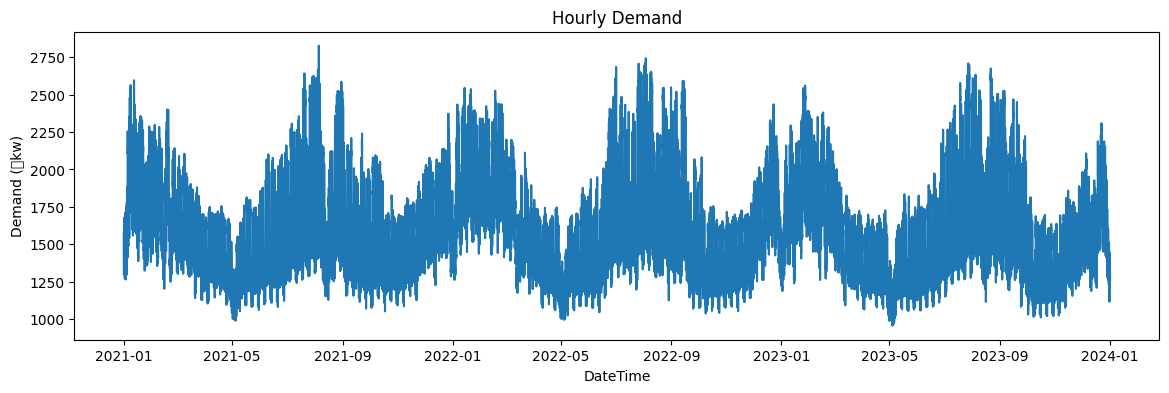

In [9]:
# plotting the demand dataframe (Time-Series Plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(demand['datetime'], demand['demand_mankw'])
plt.title('Hourly Demand')
plt.xlabel('DateTime')
plt.ylabel('Demand (万kw)')
plt.show()

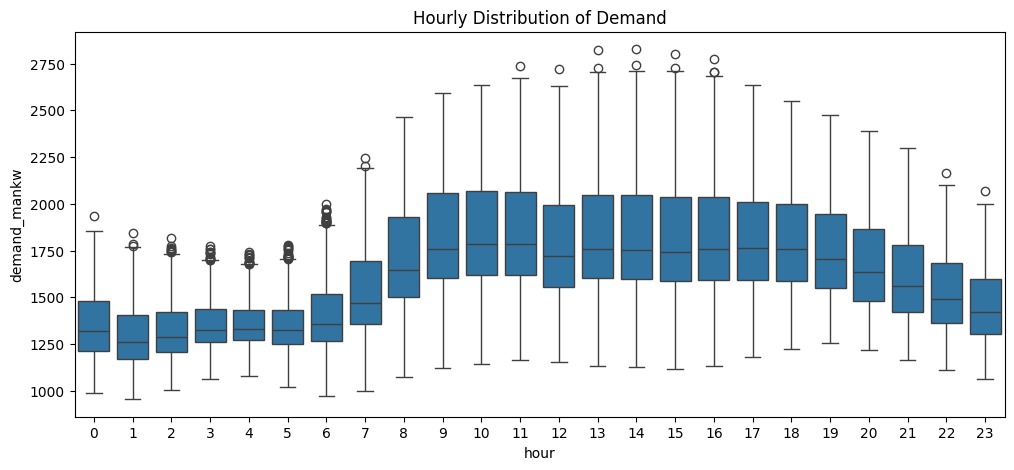

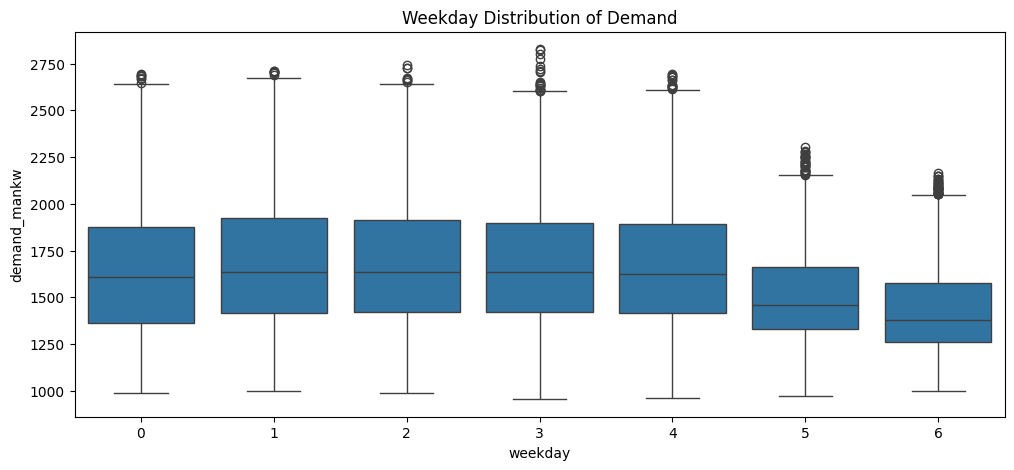

In [10]:
# Boxplots for Seasonality / Outliers
# Purpose: Identify outliers and distribution across hours or weekdays.
import seaborn as sns

demand['hour'] = demand['datetime'].dt.hour
plt.figure(figsize=(12,5))
sns.boxplot(x='hour', y='demand_mankw', data=demand)
plt.title('Hourly Distribution of Demand')
plt.show()

demand['weekday'] = demand['datetime'].dt.weekday  # 0=Monday
plt.figure(figsize=(12,5))
sns.boxplot(x='weekday', y='demand_mankw', data=demand)
plt.title('Weekday Distribution of Demand')
plt.show()


In [11]:
# Observations:
# Around April-May, Oct-Nov, demand is lowest (entire data)
# Daily hour trend: Pretty low during the early hours of the morning, rises during the day and starts falling again in the evening. (with a few outliers)
# Week analysis: Weekdays (0 - 4) pretty equal, low on the weekends

## Osaka大阪 Weather File

In [12]:
osaka_file = '大阪.csv'

# Load osaka file as a dataframe
osaka = pd.read_csv(osaka_file, parse_dates = [0])
osaka.head()

datetime  降水量   気温  露点温度    湿度   風速   風向   降雪
0 2021-01-01 00:00:00  0.0  3.1  -4.1  59.0  4.8  西南西  0.0
1 2021-01-01 01:00:00  0.0  3.0  -3.8  61.0  4.0  西南西  0.0
2 2021-01-01 02:00:00  0.0  2.9  -3.4  63.0  3.2    西  0.0
3 2021-01-01 03:00:00  0.0  2.6  -3.9  62.0  3.5  西南西  0.0
4 2021-01-01 04:00:00  0.0  2.4  -3.3  66.0  2.8   南西  0.0

In [13]:
# rename columns
osaka = osaka.rename(columns= {'降水量':'precipitation', '気温':'temp', '露点温度':'dew_point', '湿度':'humidity', '風速':'wind_speed', '風向':'wind_direction', '降雪':'snowfall'})
osaka.head()

datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   3.1       -4.1      59.0         4.8   
1 2021-01-01 01:00:00            0.0   3.0       -3.8      61.0         4.0   
2 2021-01-01 02:00:00            0.0   2.9       -3.4      63.0         3.2   
3 2021-01-01 03:00:00            0.0   2.6       -3.9      62.0         3.5   
4 2021-01-01 04:00:00            0.0   2.4       -3.3      66.0         2.8   

  wind_direction  snowfall  
0            西南西       0.0  
1            西南西       0.0  
2              西       0.0  
3            西南西       0.0  
4             南西       0.0

In [14]:
# summary stats
osaka.describe()

datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.168037     17.742275     10.666001   
min    2021-01-01 00:00:00       0.000000     -1.800000    -14.500000   
25%    2021-10-01 17:45:00       0.000000     10.500000      2.600000   
50%    2022-07-02 11:30:00       0.000000     17.800000     10.600000   
75%    2023-04-02 05:15:00       0.000000     25.200000     19.600000   
max    2023-12-31 23:00:00      48.500000     38.000000     26.600000   
std                    NaN       1.168595      8.606416      9.332281   

           humidity    wind_speed  snowfall  
count  26280.000000  26280.000000   26280.0  
mean      65.020091      2.338082       0.0  
min       11.000000      0.000000       0.0  
25%       53.000000      1.400000       0.0  
50%       65.000000      2.100000       0.0  
75%       76.000000      3.100000       0.0  
max      100.000000     12.300000       0.0  
std       16.021304      1.269907       0.0

In [15]:
osaka.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        26280 non-null  datetime64[ns]
 1   precipitation   26280 non-null  float64       
 2   temp            26280 non-null  float64       
 3   dew_point       26280 non-null  float64       
 4   humidity        26280 non-null  float64       
 5   wind_speed      26280 non-null  float64       
 6   wind_direction  26280 non-null  object        
 7   snowfall        26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.6+ MB


In [16]:
# check data types
osaka.dtypes

datetime          datetime64[ns]
precipitation            float64
temp                     float64
dew_point                float64
humidity                 float64
wind_speed               float64
wind_direction            object
snowfall                 float64
dtype: object

In [17]:
# check for null values
osaka.isnull().sum()

datetime          0
precipitation     0
temp              0
dew_point         0
humidity          0
wind_speed        0
wind_direction    0
snowfall          0
dtype: int64

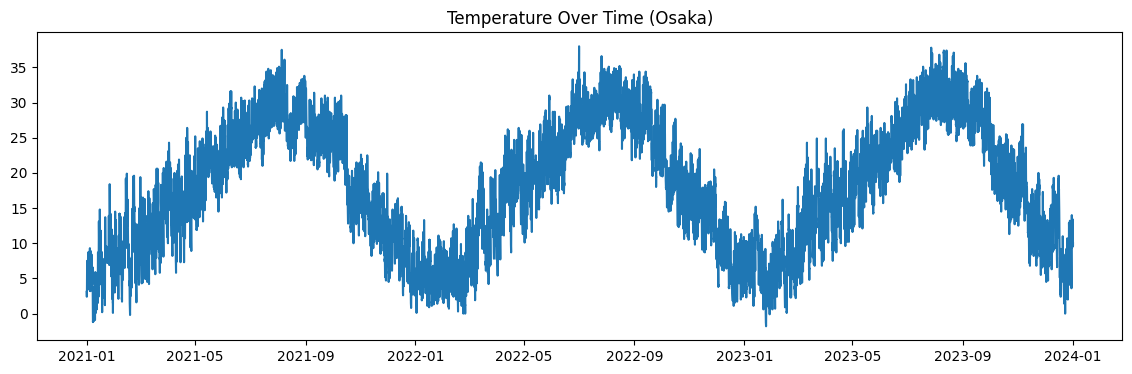

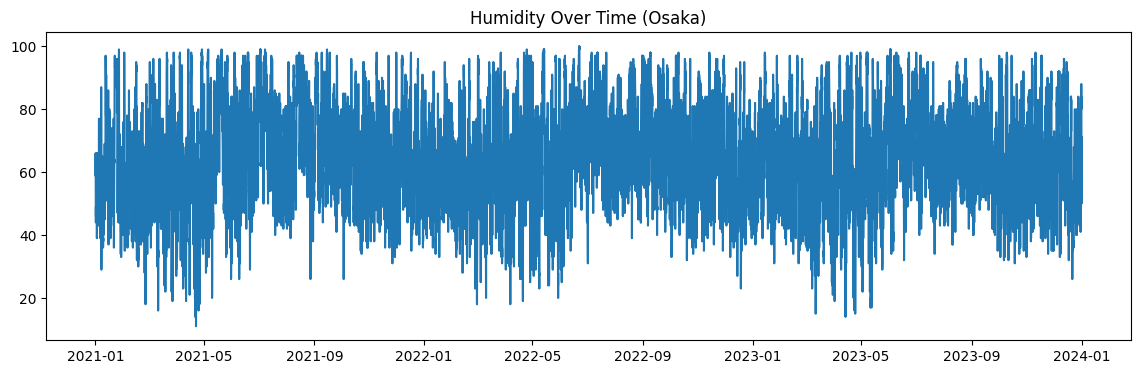

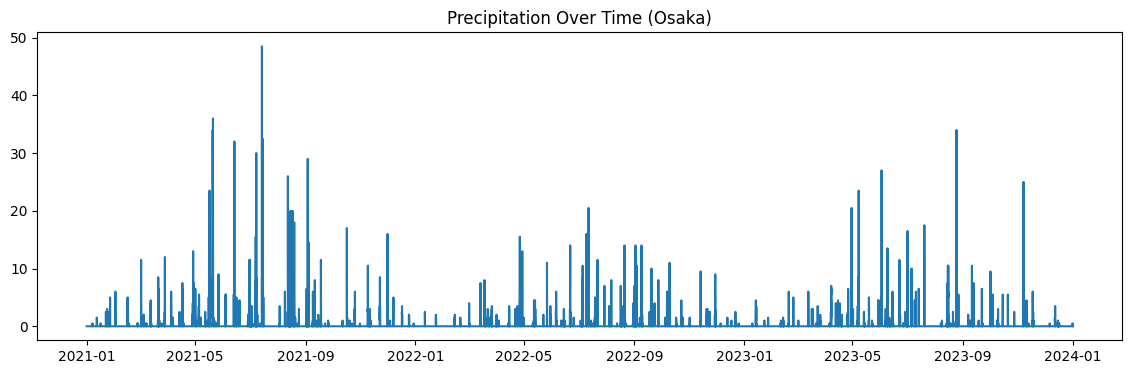

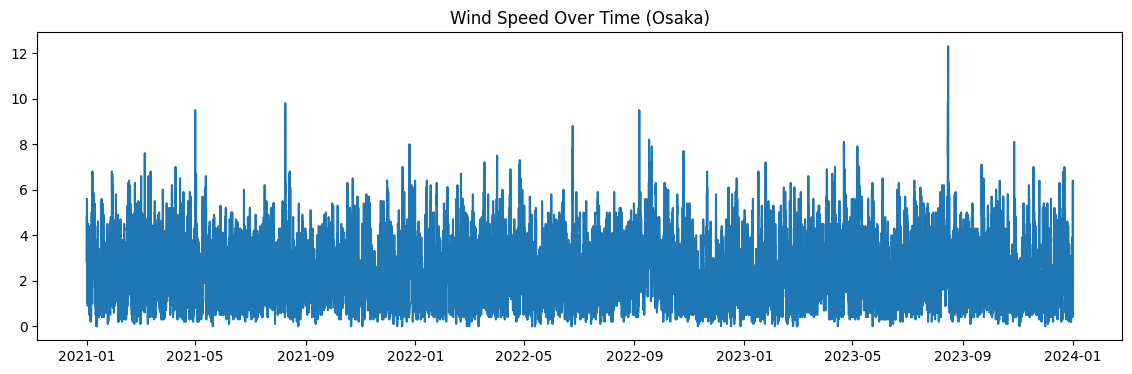

In [18]:
# Time-Series plots
# temperature, humidity, precipitation, wind speed seem most relevant for electricity demand.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(osaka['datetime'], osaka['temp'])
plt.title('Temperature Over Time (Osaka)')
plt.show()

plt.figure(figsize=(14,4))
plt.plot(osaka['datetime'], osaka['humidity'])
plt.title('Humidity Over Time (Osaka)')
plt.show()

plt.figure(figsize=(14,4))
plt.plot(osaka['datetime'], osaka['precipitation'])
plt.title('Precipitation Over Time (Osaka)')
plt.show()

plt.figure(figsize=(14,4))
plt.plot(osaka['datetime'], osaka['wind_speed'])
plt.title('Wind Speed Over Time (Osaka)')
plt.show()

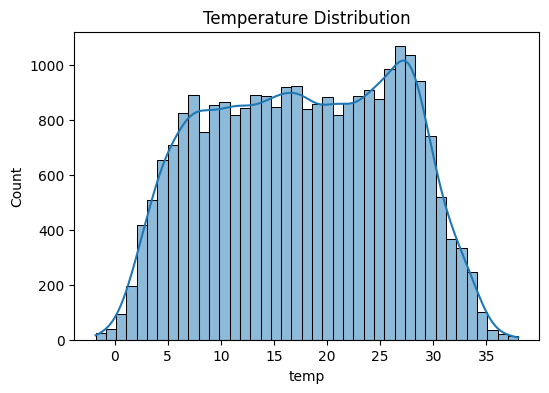

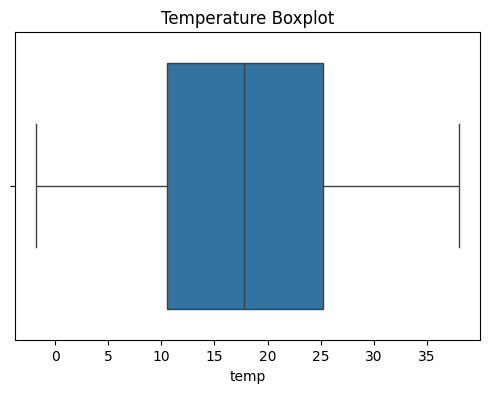

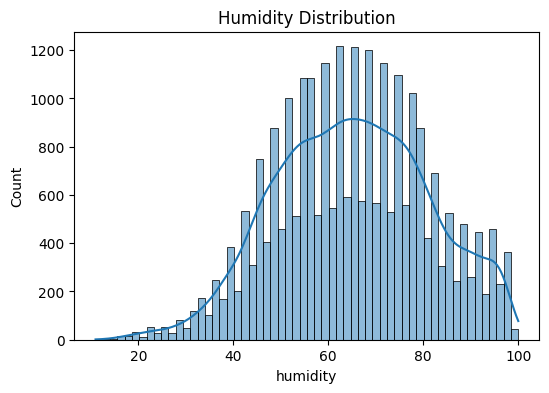

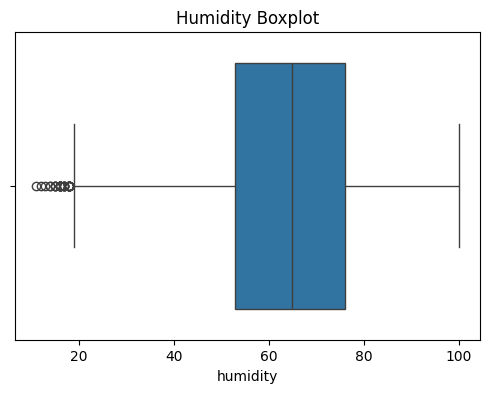

In [19]:
# Distribution (Histogram + Boxplot)
# For temperature and humidity

import seaborn as sns
plt.figure(figsize=(6,4))
sns.histplot(osaka['temp'], kde=True)
plt.title('Temperature Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=osaka['temp'])
plt.title('Temperature Boxplot')
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(osaka['humidity'], kde=True)
plt.title('Humidity Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=osaka['humidity'])
plt.title('Humidity Boxplot')
plt.show()

# Temp range 0-35, mostly between 10 - 25
# Humidity is mostly in the range of 50 - 80 (with some outliers < 20)


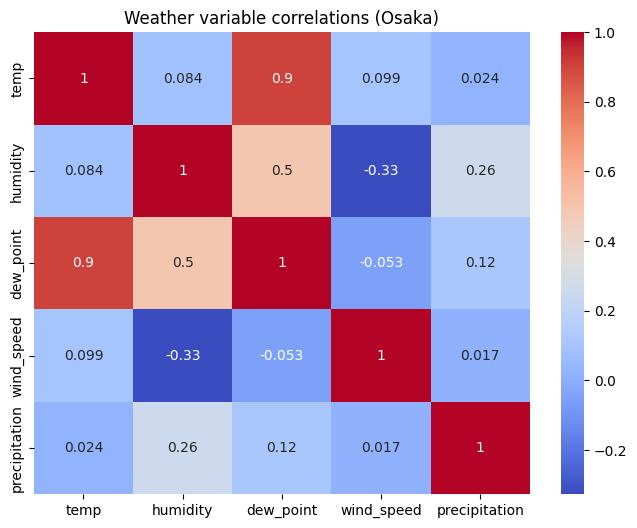

In [20]:
# Correlation Heatmap
# how the variables relate to each other
plt.figure(figsize=(8,6))
sns.heatmap(osaka[['temp','humidity','dew_point','wind_speed','precipitation']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Weather variable correlations (Osaka)')
plt.show()
# temp and dew point are highly correlated
# humidity and dew point have 50% correlation

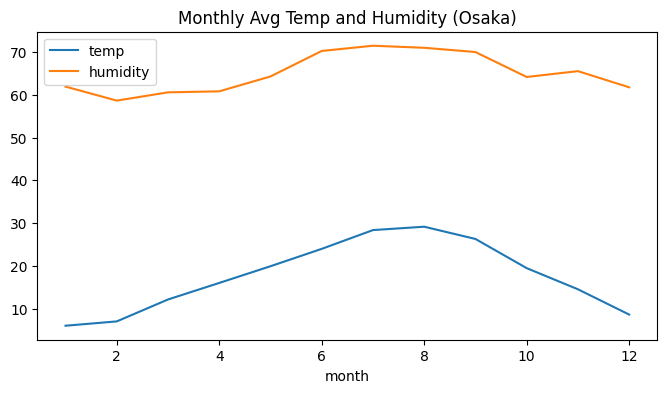

In [21]:
# Monthly averages
osaka['month'] = osaka['datetime'].dt.month
monthly = osaka.groupby('month')[['temp', 'humidity']].mean()

monthly.plot(kind = 'line', figsize=(8,4), title='Monthly Avg Temp and Humidity (Osaka)')
plt.show()

# temp is rises from Feb, peaks around July, Aug and then starts falling again
# humidity is lower during winter (Feb to Apr) starts rising again, max during summer

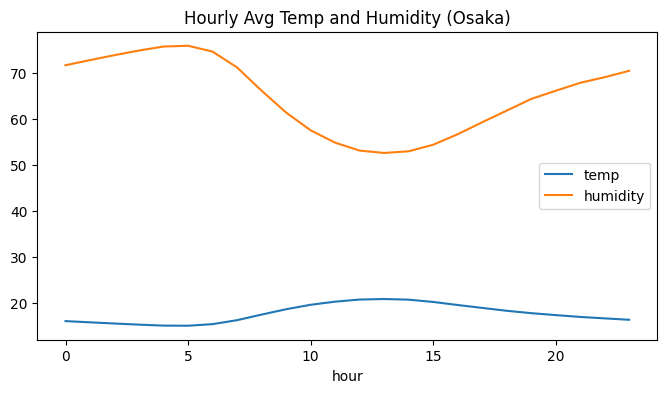

In [22]:
# Hourly averages (is it needed?)

osaka['hour'] = osaka['datetime'].dt.hour
hourly = osaka.groupby('hour')[['temp', 'humidity']].mean()

hourly.plot(kind='line', figsize=(8,4), title = 'Hourly Avg Temp and Humidity (Osaka)')
plt.show()

## Other Weather Files (Apart from Osaka)

In [23]:
weather_files = [
      "京都.csv",
      "和歌山.csv",
      "彦根.csv",
      "潮岬.csv",
      "神戸.csv",
      "豊岡.csv"
  ]

weather_dfs = {}

for file in weather_files:
    df = pd.read_csv(file, parse_dates=["datetime"])
    weather_dfs[file] = df

In [24]:
# list out all the column names in all the files
for file, df in weather_dfs.items():
    print(file, df.columns.tolist())

京都.csv ['datetime', '降水量', '気温', '露点温度', '湿度', '風速', '風向', '降雪']
和歌山.csv ['datetime', '降水量', '気温', '露点温度', '湿度', '風速', '風向', '降雪']
彦根.csv ['datetime', '降水量', '気温', '露点温度', '湿度', '風速', '風向', '降雪']
潮岬.csv ['datetime', '降水量', '気温', '露点温度', '湿度', '風速', '風向', '降雪']
神戸.csv ['datetime', '降水量', '気温', '露点温度', '湿度', '風速', '風向', '降雪']
豊岡.csv ['datetime', '降水量', '気温', '露点温度', '湿度', '風速', '風向', '降雪']


In [25]:
def quick_weather_check(df, name="weather"):

    print(f"========= {name} =========")

    # rename columns
    df = df.rename(columns= {'降水量':'precipitation', '気温':'temp', '露点温度':'dew_point', '湿度':'humidity', '風速':'wind_speed', '風向':'wind_direction', '降雪':'snowfall'})

    print("\nHead:")
    display(df.head())

    print("\nInfo:")
    display(df.info())

    print("\nMissing values:")
    display(df.isnull().sum())

    print("\nDescription:")
    display(df.describe())

    print("\n", "="*70, "\n")

In [26]:
for file, df in weather_dfs.items():
    quick_weather_check(df, name=file)


========= 京都.csv =========

Head:


datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   0.6       -5.0      66.0         2.1   
1 2021-01-01 01:00:00            0.0   0.5       -4.9      67.0         1.5   
2 2021-01-01 02:00:00            0.0   0.2       -5.0      68.0         0.9   
3 2021-01-01 03:00:00            0.0   0.0       -4.6      71.0         1.8   
4 2021-01-01 04:00:00            0.0   0.0       -4.6      71.0         2.3   

  wind_direction  snowfall  
0            南南西       0.0  
1            南南西       0.0  
2             北東       0.0  
3              南       0.0  
4             北西       0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        26280 non-null  datetime64[ns]
 1   precipitation   26280 non-null  float64       
 2   temp            26280 non-null  float64       
 3   dew_point       26280 non-null  float64       
 4   humidity        26280 non-null  float64       
 5   wind_speed      26280 non-null  float64       
 6   wind_direction  26280 non-null  object        
 7   snowfall        26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.6+ MB


None


Missing values:


datetime          0
precipitation     0
temp              0
dew_point         0
humidity          0
wind_speed        0
wind_direction    0
snowfall          0
dtype: int64


Description:


datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.184113     17.088577     10.375472   
min    2021-01-01 00:00:00       0.000000     -3.900000    -15.800000   
25%    2021-10-01 17:45:00       0.000000      9.300000      2.300000   
50%    2022-07-02 11:30:00       0.000000     17.200000     10.200000   
75%    2023-04-02 05:15:00       0.000000     24.900000     19.000000   
max    2023-12-31 23:00:00      64.000000     38.100000     26.200000   
std                    NaN       1.290495      9.197685      9.038824   

           humidity    wind_speed      snowfall  
count  26280.000000  26280.000000  26280.000000  
mean      66.880251      2.007728      0.001903  
min        9.000000      0.000000      0.000000  
25%       55.000000      1.100000      0.000000  
50%       69.000000      1.700000      0.000000  
75%       80.000000      2.700000      0.000000  
max       99.000000     12.000000      7.000000  
std       16.448775      1.230424      0.069218



========= 和歌山.csv =========

Head:


datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   2.3       -1.0      79.0         2.6   
1 2021-01-01 01:00:00            0.0   3.1       -2.2      68.0         1.5   
2 2021-01-01 02:00:00            0.0   3.9       -4.1      56.0         6.2   
3 2021-01-01 03:00:00            0.0   3.9       -3.4      59.0         5.6   
4 2021-01-01 04:00:00            0.0   3.9       -3.1      60.0         5.8   

  wind_direction  snowfall  
0            西南西       0.0  
1              北       0.0  
2            西北西       0.0  
3            西北西       0.0  
4            西北西       0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        26280 non-null  datetime64[ns]
 1   precipitation   26280 non-null  float64       
 2   temp            26280 non-null  float64       
 3   dew_point       26280 non-null  float64       
 4   humidity        26280 non-null  float64       
 5   wind_speed      26280 non-null  float64       
 6   wind_direction  26280 non-null  object        
 7   snowfall        26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.6+ MB


None


Missing values:


datetime          0
precipitation     0
temp              0
dew_point         0
humidity          0
wind_speed        0
wind_direction    0
snowfall          0
dtype: int64


Description:


datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.152188     17.553554     11.485963   
min    2021-01-01 00:00:00       0.000000     -1.600000    -12.300000   
25%    2021-10-01 17:45:00       0.000000     10.600000      3.400000   
50%    2022-07-02 11:30:00       0.000000     17.900000     11.400000   
75%    2023-04-02 05:15:00       0.000000     24.900000     20.400000   
max    2023-12-31 23:00:00      41.500000     36.700000     27.100000   
std                    NaN       1.059075      8.402013      9.298006   

           humidity    wind_speed      snowfall  
count  26280.000000  26280.000000  26280.000000  
mean      69.092656      3.797009      0.000228  
min        0.000000      0.000000      0.000000  
25%       58.000000      2.200000      0.000000  
50%       70.000000      3.400000      0.000000  
75%       81.000000      4.900000      0.000000  
max      100.000000     19.200000      3.000000  
std       15.573367      2.197436      0.021368



========= 彦根.csv =========

Head:


datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   0.3       -4.9      68.0         3.8   
1 2021-01-01 01:00:00            0.0   0.3       -4.7      69.0         3.7   
2 2021-01-01 02:00:00            0.0   0.0       -4.8      70.0         3.5   
3 2021-01-01 03:00:00            0.0  -0.8       -4.7      75.0         2.3   
4 2021-01-01 04:00:00            0.0   0.2       -4.0      73.0         2.5   

  wind_direction  snowfall  
0              南       0.0  
1            南南西       0.0  
2            南南西       0.0  
3            南南東       0.0  
4            南南西       0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        26280 non-null  datetime64[ns]
 1   precipitation   26280 non-null  float64       
 2   temp            26280 non-null  float64       
 3   dew_point       26280 non-null  float64       
 4   humidity        26280 non-null  float64       
 5   wind_speed      26280 non-null  float64       
 6   wind_direction  26280 non-null  object        
 7   snowfall        26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.6+ MB


None


Missing values:


datetime          0
precipitation     0
temp              0
dew_point         0
humidity          0
wind_speed        0
wind_direction    0
snowfall          0
dtype: int64


Description:


datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.177759     15.942127     11.345837   
min    2021-01-01 00:00:00       0.000000     -4.200000    -17.400000   
25%    2021-10-01 17:45:00       0.000000      8.200000      3.600000   
50%    2022-07-02 11:30:00       0.000000     15.800000     11.000000   
75%    2023-04-02 05:15:00       0.000000     23.900000     19.700000   
max    2023-12-31 23:00:00      37.500000     36.400000     27.000000   
std                    NaN       0.973132      9.035720      8.774529   

           humidity    wind_speed      snowfall  
count  26280.000000  26280.000000  26280.000000  
mean      75.445358      2.881001      0.010464  
min        0.000000      0.000000      0.000000  
25%       66.000000      1.400000      0.000000  
50%       77.000000      2.200000      0.000000  
75%       86.000000      3.800000      0.000000  
max      100.000000     15.800000      7.000000  
std       14.289113      2.067910      0.164385



========= 潮岬.csv =========

Head:


datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   3.7       -4.2      56.0         6.7   
1 2021-01-01 01:00:00            0.0   4.1       -3.6      57.0         8.0   
2 2021-01-01 02:00:00            0.0   4.0       -4.4      54.0         6.9   
3 2021-01-01 03:00:00            0.0   4.1       -3.4      58.0         7.1   
4 2021-01-01 04:00:00            0.0   4.6       -2.3      61.0         7.0   

  wind_direction  snowfall  
0            西北西       0.0  
1            西北西       0.0  
2            西北西       0.0  
3            西北西       0.0  
4            西北西       0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        26280 non-null  datetime64[ns]
 1   precipitation   26280 non-null  float64       
 2   temp            26280 non-null  float64       
 3   dew_point       26280 non-null  float64       
 4   humidity        26280 non-null  float64       
 5   wind_speed      26280 non-null  float64       
 6   wind_direction  26280 non-null  object        
 7   snowfall        26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.6+ MB


None


Missing values:


datetime          0
precipitation     0
temp              0
dew_point         0
humidity          0
wind_speed        0
wind_direction    0
snowfall          0
dtype: int64


Description:


datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.280042     17.983505     13.165011   
min    2021-01-01 00:00:00       0.000000     -1.800000    -11.900000   
25%    2021-10-01 17:45:00       0.000000     12.700000      5.600000   
50%    2022-07-02 11:30:00       0.000000     18.200000     14.200000   
75%    2023-04-02 05:15:00       0.000000     24.200000     21.800000   
max    2023-12-31 23:00:00      57.000000     31.900000     28.000000   
std                    NaN       1.723939      7.036041      9.491825   

           humidity    wind_speed  snowfall  
count  26280.000000  26280.000000   26280.0  
mean      74.757610      3.970000       0.0  
min        0.000000      0.000000       0.0  
25%       60.000000      2.500000       0.0  
50%       77.000000      3.500000       0.0  
75%       91.000000      5.100000       0.0  
max      100.000000     17.400000       0.0  
std       18.187292      2.042015       0.0



========= 神戸.csv =========

Head:


datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   2.2       -3.7      65.0         5.7   
1 2021-01-01 01:00:00            0.0   2.5       -3.4      65.0         4.3   
2 2021-01-01 02:00:00            0.0   2.1       -3.2      68.0         4.5   
3 2021-01-01 03:00:00            0.0   1.5       -3.9      67.0         4.5   
4 2021-01-01 04:00:00            0.0   1.8       -3.7      67.0         3.5   

  wind_direction  snowfall  
0              西       0.0  
1            西南西       0.0  
2              西       0.0  
3              西       0.0  
4              西       0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        26280 non-null  datetime64[ns]
 1   precipitation   26280 non-null  float64       
 2   temp            26280 non-null  float64       
 3   dew_point       26280 non-null  float64       
 4   humidity        26280 non-null  float64       
 5   wind_speed      26280 non-null  float64       
 6   wind_direction  26280 non-null  object        
 7   snowfall        26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.6+ MB


None


Missing values:


datetime          0
precipitation     0
temp              0
dew_point         0
humidity          0
wind_speed        0
wind_direction    0
snowfall          0
dtype: int64


Description:


datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.155137     17.717146     11.014448   
min    2021-01-01 00:00:00       0.000000     -2.700000    -15.100000   
25%    2021-10-01 17:45:00       0.000000     10.800000      2.900000   
50%    2022-07-02 11:30:00       0.000000     17.900000     11.100000   
75%    2023-04-02 05:15:00       0.000000     25.100000     19.900000   
max    2023-12-31 23:00:00      52.000000     36.300000     27.100000   
std                    NaN       1.134157      8.344939      9.479882   

           humidity    wind_speed      snowfall  
count  26280.000000  26280.000000  26280.000000  
mean      66.144977      3.551244      0.000152  
min        0.000000      0.000000      0.000000  
25%       56.000000      2.100000      0.000000  
50%       66.000000      3.200000      0.000000  
75%       77.000000      4.700000      0.000000  
max      100.000000     22.500000      2.000000  
std       14.933896      1.997644      0.015109



========= 豊岡.csv =========

Head:


datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.5  -0.3       -0.4      99.0         2.1   
1 2021-01-01 01:00:00            1.5  -0.2       -0.3      99.0         2.0   
2 2021-01-01 02:00:00            0.5   0.4        0.0      97.0         3.5   
3 2021-01-01 03:00:00            1.0   0.1        0.1     100.0         2.2   
4 2021-01-01 04:00:00            0.5   0.2        0.2     100.0         2.8   

  wind_direction  snowfall  
0            南南東       1.0  
1              南       2.0  
2             南西       0.0  
3            南南東       2.0  
4              南       0.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        26280 non-null  datetime64[ns]
 1   precipitation   26280 non-null  float64       
 2   temp            26280 non-null  float64       
 3   dew_point       26280 non-null  float64       
 4   humidity        26280 non-null  float64       
 5   wind_speed      26280 non-null  float64       
 6   wind_direction  26280 non-null  object        
 7   snowfall        26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.6+ MB


None


Missing values:


datetime          0
precipitation     0
temp              0
dew_point         0
humidity          0
wind_speed        0
wind_direction    0
snowfall          0
dtype: int64


Description:


datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.221709     15.484247     11.377960   
min    2021-01-01 00:00:00       0.000000     -6.300000    -15.800000   
25%    2021-10-01 17:45:00       0.000000      7.200000      3.600000   
50%    2022-07-02 11:30:00       0.000000     15.600000     10.900000   
75%    2023-04-02 05:15:00       0.000000     23.600000     20.000000   
max    2023-12-31 23:00:00      49.000000     38.400000     26.700000   
std                    NaN       1.034692      9.529538      8.629026   

           humidity    wind_speed      snowfall  
count  26280.000000  26280.000000  26280.000000  
mean      78.895244      1.772789      0.019901  
min        0.000000      0.000000      0.000000  
25%       66.000000      0.800000      0.000000  
50%       85.000000      1.300000      0.000000  
75%       95.000000      2.500000      0.000000  
max      100.000000     10.200000      6.000000  
std       19.063281      1.307035      0.205391

In [27]:
# List out how the temperature is in all the locations: max, min, avg
#for file, df in weather_dfs.items():
    #print(file, df['気温'].describe())

## Merging all weather files

In [28]:
# List of 7 weather files
weather_files = [
      "大阪.csv",
      "京都.csv",
      "和歌山.csv",
      "彦根.csv",
      "潮岬.csv",
      "神戸.csv",
      "豊岡.csv"
  ]

In [29]:
# load each csv, add city column, store in a list

weather_dfs = []
for file in weather_files:
  city_name = file.split('.')[0] # using file name as city name
  df = pd.read_csv(file, parse_dates=[0])
  df['city'] = city_name # creating a column to add the city name
  weather_dfs.append(df) # adding all the dataframes to a list

In [30]:
# concatenate all cities dataframes into one long dataframe

weather_all = pd.concat(weather_dfs, ignore_index=True)

In [31]:
weather_all.head()

datetime  降水量   気温  露点温度    湿度   風速   風向   降雪 city
0 2021-01-01 00:00:00  0.0  3.1  -4.1  59.0  4.8  西南西  0.0   大阪
1 2021-01-01 01:00:00  0.0  3.0  -3.8  61.0  4.0  西南西  0.0   大阪
2 2021-01-01 02:00:00  0.0  2.9  -3.4  63.0  3.2    西  0.0   大阪
3 2021-01-01 03:00:00  0.0  2.6  -3.9  62.0  3.5  西南西  0.0   大阪
4 2021-01-01 04:00:00  0.0  2.4  -3.3  66.0  2.8   南西  0.0   大阪

In [32]:
#rename columns
weather_all = weather_all.rename(columns= {'降水量':'precipitation', '気温':'temp', '露点温度':'dew_point', '湿度':'humidity', '風速':'wind_speed', '風向':'wind_direction', '降雪':'snowfall'})

In [33]:
weather_all.head()

datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   3.1       -4.1      59.0         4.8   
1 2021-01-01 01:00:00            0.0   3.0       -3.8      61.0         4.0   
2 2021-01-01 02:00:00            0.0   2.9       -3.4      63.0         3.2   
3 2021-01-01 03:00:00            0.0   2.6       -3.9      62.0         3.5   
4 2021-01-01 04:00:00            0.0   2.4       -3.3      66.0         2.8   

  wind_direction  snowfall city  
0            西南西       0.0   大阪  
1            西南西       0.0   大阪  
2              西       0.0   大阪  
3            西南西       0.0   大阪  
4             南西       0.0   大阪

In [34]:
# dropping wind direction and city name column since it cannot be combined across all 7 cities


weather_all = weather_all.drop(['wind_direction', 'city'], axis=1)


# NOTE: wind direction can be converted to vectors and then combined (future improvement)

In [35]:
weather_all.head()

datetime  precipitation  temp  dew_point  humidity  wind_speed  \
0 2021-01-01 00:00:00            0.0   3.1       -4.1      59.0         4.8   
1 2021-01-01 01:00:00            0.0   3.0       -3.8      61.0         4.0   
2 2021-01-01 02:00:00            0.0   2.9       -3.4      63.0         3.2   
3 2021-01-01 03:00:00            0.0   2.6       -3.9      62.0         3.5   
4 2021-01-01 04:00:00            0.0   2.4       -3.3      66.0         2.8   

   snowfall  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [36]:
# aggregate weather by datetime (average across cities)

weather_agg = weather_all.groupby('datetime').mean().reset_index()

In [37]:
weather_agg.head()

datetime  precipitation      temp  dew_point   humidity  \
0 2021-01-01 00:00:00       0.071429  1.700000  -3.328571  70.285714   
1 2021-01-01 01:00:00       0.214286  1.900000  -3.271429  69.428571   
2 2021-01-01 02:00:00       0.071429  1.928571  -3.557143  68.000000   
3 2021-01-01 03:00:00       0.142857  1.628571  -3.400000  70.285714   
4 2021-01-01 04:00:00       0.071429  1.871429  -2.971429  71.142857   

   wind_speed  snowfall  
0    3.971429  0.142857  
1    3.571429  0.285714  
2    4.100000  0.000000  
3    3.857143  0.285714  
4    3.814286  0.000000

In [38]:
weather_agg.describe()

datetime  precipitation          temp     dew_point  \
count                26280   26280.000000  26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.191283     17.073062     11.347242   
min    2021-01-01 00:00:00       0.000000     -2.285714    -11.457143   
25%    2021-10-01 17:45:00       0.000000      9.942857      3.471429   
50%    2022-07-02 11:30:00       0.000000     17.228571     11.128571   
75%    2023-04-02 05:15:00       0.000000     24.585714     19.946429   
max    2023-12-31 23:00:00      14.928571     34.885714     25.928571   
std                    NaN       0.720607      8.505832      9.028614   

           humidity    wind_speed      snowfall  
count  26280.000000  26280.000000  26280.000000  
mean      70.890884      2.902551      0.004664  
min       23.285714      0.642857      0.000000  
25%       61.571429      1.971429      0.000000  
50%       71.714286      2.657143      0.000000  
75%       80.857143      3.614286      0.000000  
max       99.000000     11.957143      2.000000  
std       13.411297      1.197059      0.044657

In [39]:
# load demand file
demand = pd.read_csv('電力需要.csv', parse_dates=[0])
demand = demand.rename(columns={'当日実績(万kW)': 'demand_mankw'})

In [40]:
demand.head()

datetime  demand_mankw
0 2021-01-01 00:00:00          1571
1 2021-01-01 01:00:00          1492
2 2021-01-01 02:00:00          1453
3 2021-01-01 03:00:00          1412
4 2021-01-01 04:00:00          1358

In [41]:
# merging the aggregate weather with demand
data = pd.merge(demand, weather_agg, on='datetime', how='left')

In [42]:
data.head()

datetime  demand_mankw  precipitation      temp  dew_point  \
0 2021-01-01 00:00:00          1571       0.071429  1.700000  -3.328571   
1 2021-01-01 01:00:00          1492       0.214286  1.900000  -3.271429   
2 2021-01-01 02:00:00          1453       0.071429  1.928571  -3.557143   
3 2021-01-01 03:00:00          1412       0.142857  1.628571  -3.400000   
4 2021-01-01 04:00:00          1358       0.071429  1.871429  -2.971429   

    humidity  wind_speed  snowfall  
0  70.285714    3.971429  0.142857  
1  69.428571    3.571429  0.285714  
2  68.000000    4.100000  0.000000  
3  70.285714    3.857143  0.285714  
4  71.142857    3.814286  0.000000

## Exploratory Data Analysis (EDA)

### Time-Series Analysis

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

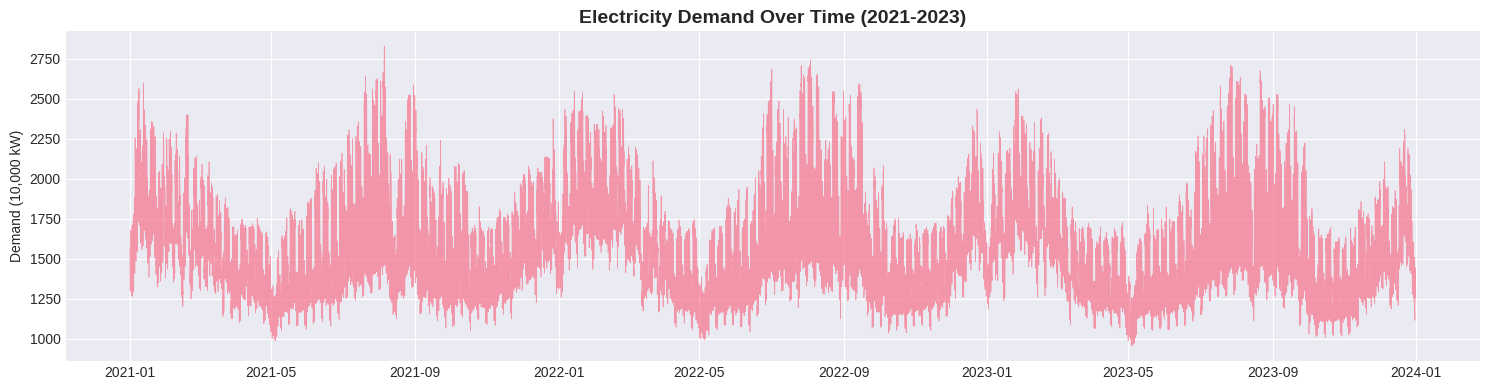

In [44]:
# 1. Overall demand trend
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(data['datetime'], data['demand_mankw'], linewidth=0.5, alpha=0.7)
ax.set_title('Electricity Demand Over Time (2021-2023)', fontsize=14, fontweight='bold')
ax.set_ylabel('Demand (10,000 kW)')
plt.tight_layout()
plt.show()

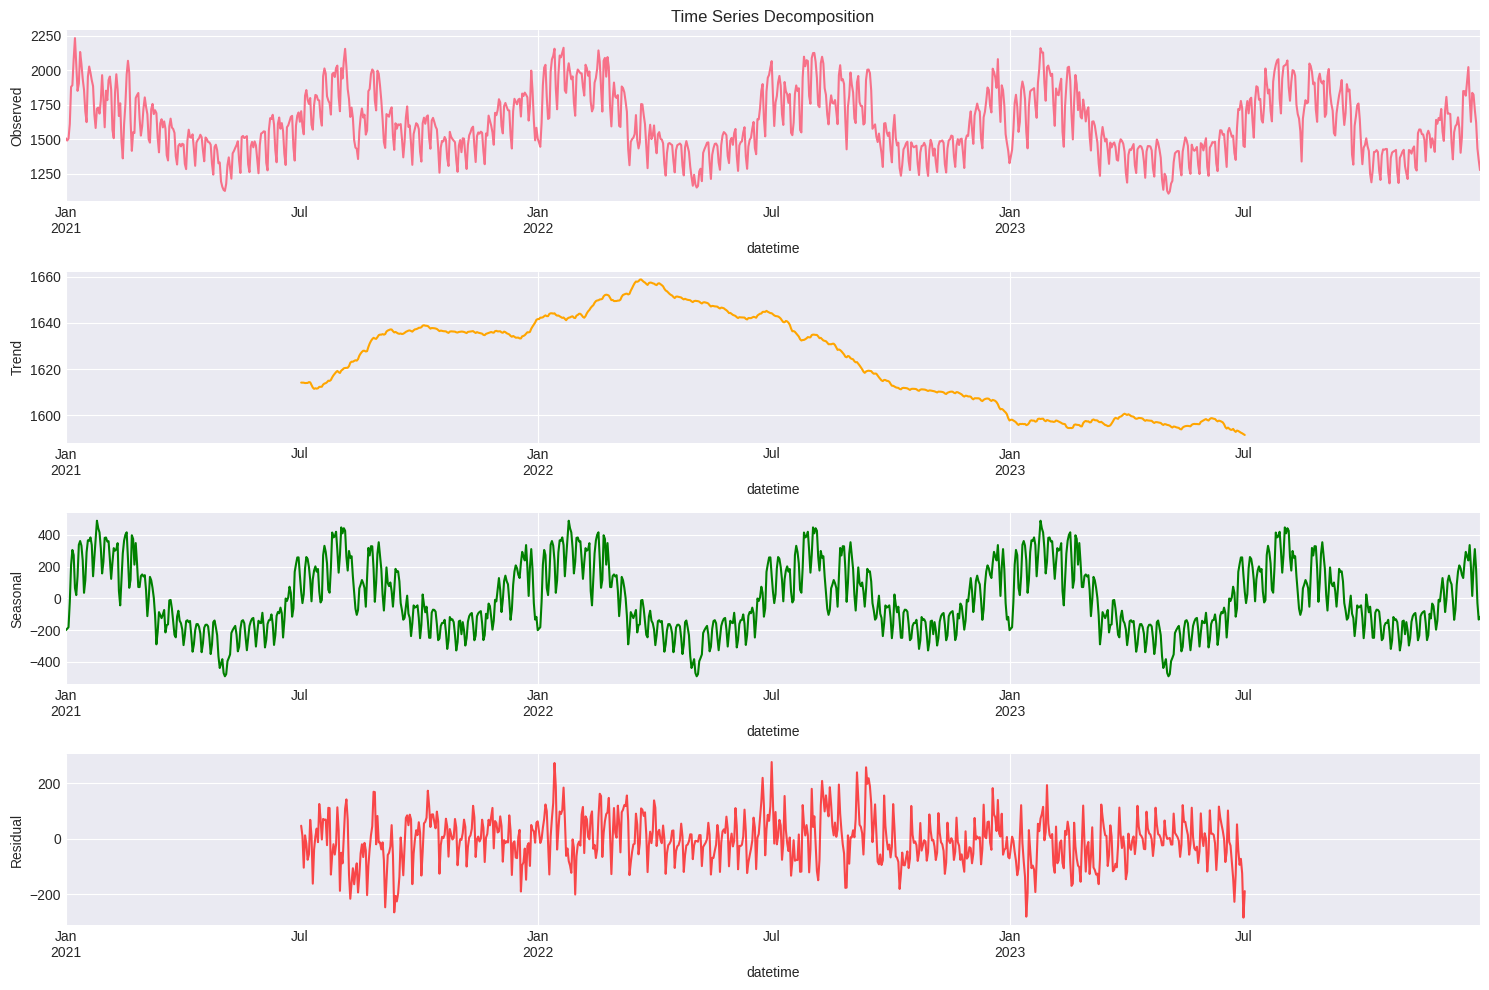

In [45]:
# 2. Time Series Decomposition

# Set datetime as index temporarily for resampling
data_temp = data.set_index('datetime')

# Resample to daily average
df_daily = data_temp['demand_mankw'].resample('D').mean() # daily average created to see patterns (hourly data difficult)

# Decompose: breaks the time series into 3 parts (observed = trend + seasonal + residual)
decomposition = seasonal_decompose(df_daily, model='additive', period=365)

# Plot
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposition.observed.plot(ax=axes[0], title='Time Series Decomposition') # actual raw data (shows daily average demand)
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], color='orange') # trend shows the long term direction: is demand going up or down or staying flat over 3 years
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], color='green') # patterns that repeat at regular intervals
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], color='red', alpha=0.7) # leftover noise after removing trend and seasonal patterns
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

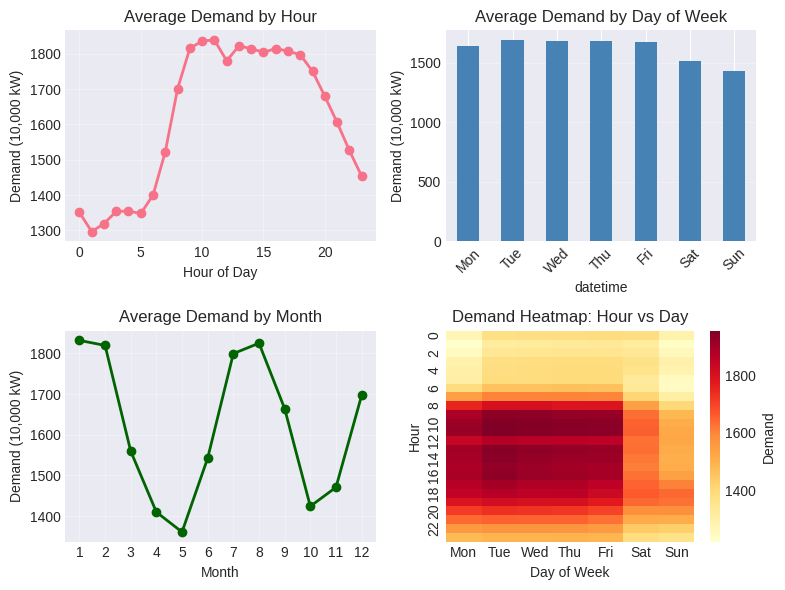

In [46]:
# 3. TEMPORAL PATTERN ANALYSIS : KEY PATTERNS (2x2 Grid)

# Set datetime as index temporarily
data_indexed = data.set_index('datetime')

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Hourly pattern
hourly = data_indexed.groupby(data_indexed.index.hour)['demand_mankw'].mean()
hourly.plot(ax=axes[0,0], marker='o', linewidth=2)
axes[0,0].set_title('Average Demand by Hour')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Demand (10,000 kW)')
axes[0,0].grid(True, alpha=0.3)

# Day of week pattern
daily = data_indexed.groupby(data_indexed.index.dayofweek)['demand_mankw'].mean()
daily.plot(ax=axes[0,1], kind='bar', color='steelblue')
axes[0,1].set_title('Average Demand by Day of Week')
axes[0,1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
axes[0,1].set_ylabel('Demand (10,000 kW)')
axes[0,1].grid(True, alpha=0.3, axis='y')

# Monthly pattern
monthly = data_indexed.groupby(data_indexed.index.month)['demand_mankw'].mean()
monthly.plot(ax=axes[1,0], marker='o', linewidth=2, color='darkgreen')
axes[1,0].set_title('Average Demand by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Demand (10,000 kW)')
axes[1,0].set_xticks(range(1,13))
axes[1,0].grid(True, alpha=0.3)

# Heatmap: Hour vs Day of Week
pivot = data_indexed.pivot_table(values='demand_mankw', index=data_indexed.index.hour,
                                  columns=data_indexed.index.dayofweek, aggfunc='mean')
sns.heatmap(pivot, cmap='YlOrRd', ax=axes[1,1], cbar_kws={'label': 'Demand'})
axes[1,1].set_title('Demand Heatmap: Hour vs Day')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Hour')
axes[1,1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

In [47]:
# 4. SUMMARY STATS

print("DEMAND SUMMARY:")
print(data['demand_mankw'].describe())
print(f"\nPeak Hour: {hourly.idxmax()}:00") # hour with highest average demand
print(f"Peak Month: {monthly.idxmax()}") # month with highest average demand

DEMAND SUMMARY:
count    26280.000000
mean      1616.426180
std        328.186899
min        955.000000
25%       1359.000000
50%       1572.000000
75%       1816.000000
max       2827.000000
Name: demand_mankw, dtype: float64

Peak Hour: 11:00
Peak Month: 1


### Weather Correlation Analysis

In [48]:
# Select relevant columns for correlation
weather_cols = ['demand_mankw', 'temp', 'humidity', 'precipitation', 'wind_speed']
corr_data = data[weather_cols].dropna()

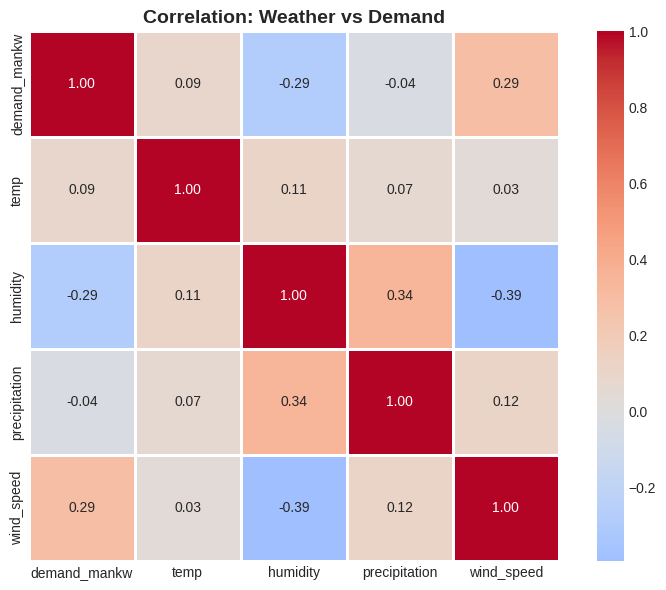

CORRELATION WITH DEMAND:
demand_mankw     1.000000
wind_speed       0.289277
temp             0.092599
precipitation   -0.037248
humidity        -0.287899
Name: demand_mankw, dtype: float64


In [49]:
# 1. Correlation Matrix

plt.figure(figsize=(8, 6))
correlation = corr_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=1)
plt.title('Correlation: Weather vs Demand', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("CORRELATION WITH DEMAND:")
print(correlation['demand_mankw'].sort_values(ascending=False))

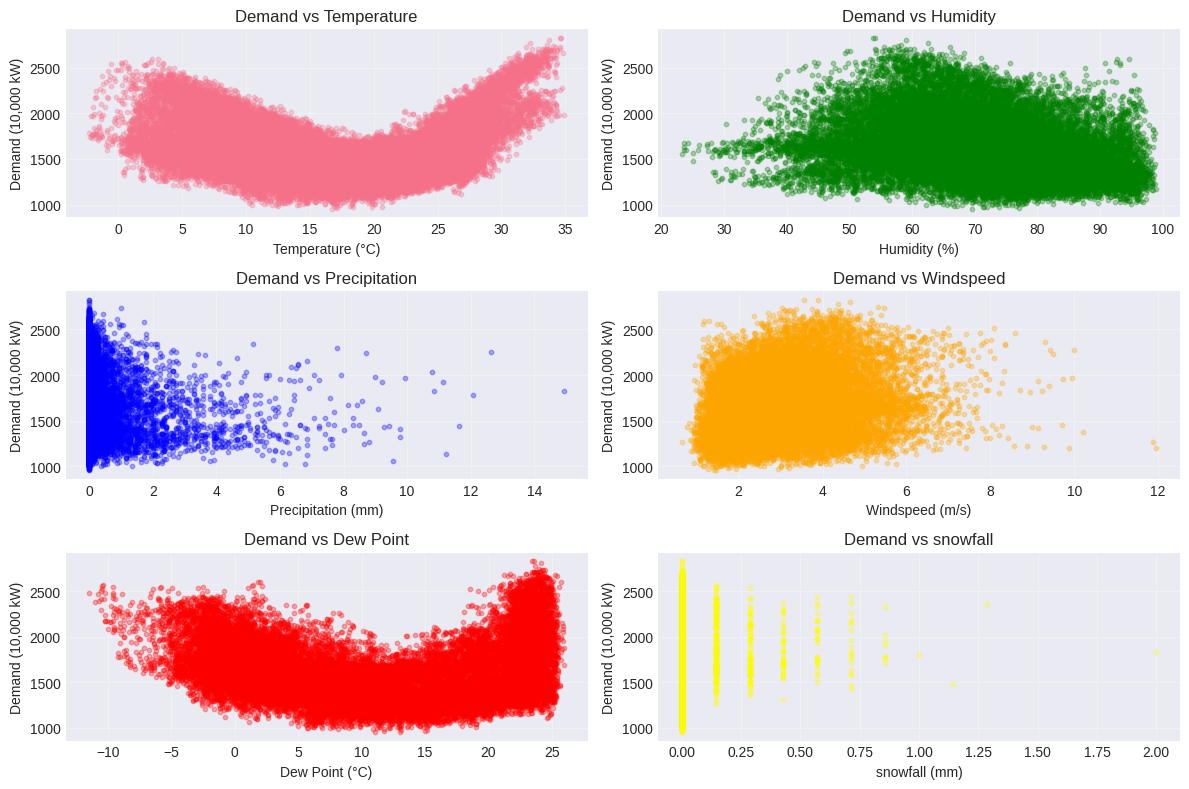

In [50]:
# B. KEY WEATHER DRIVERS (Scatter Plots)

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Temperature vs Demand
axes[0,0].scatter(data['temp'], data['demand_mankw'], alpha=0.3, s=10)
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Demand (10,000 kW)')
axes[0,0].set_title('Demand vs Temperature')
axes[0,0].grid(True, alpha=0.3)

# Humidity vs Demand
axes[0,1].scatter(data['humidity'], data['demand_mankw'], alpha=0.3, s=10, color='green')
axes[0,1].set_xlabel('Humidity (%)')
axes[0,1].set_ylabel('Demand (10,000 kW)')
axes[0,1].set_title('Demand vs Humidity')
axes[0,1].grid(True, alpha=0.3)

# Precipitation vs Demand
axes[1,0].scatter(data['precipitation'], data['demand_mankw'], alpha=0.3, s=10, color='blue')
axes[1,0].set_xlabel('Precipitation (mm)')
axes[1,0].set_ylabel('Demand (10,000 kW)')
axes[1,0].set_title('Demand vs Precipitation')
axes[1,0].grid(True, alpha=0.3)

# Windspeed vs Demand
axes[1,1].scatter(data['wind_speed'], data['demand_mankw'], alpha=0.3, s=10, color='orange')
axes[1,1].set_xlabel('Windspeed (m/s)')
axes[1,1].set_ylabel('Demand (10,000 kW)')
axes[1,1].set_title('Demand vs Windspeed')
axes[1,1].grid(True, alpha=0.3)

# Dew Point vs Demand
axes[2,0].scatter(data['dew_point'], data['demand_mankw'], alpha=0.3, s=10, color='red')
axes[2,0].set_xlabel('Dew Point (°C)')
axes[2,0].set_ylabel('Demand (10,000 kW)')
axes[2,0].set_title('Demand vs Dew Point')
axes[2,0].grid(True, alpha=0.3)

# Snowfall vs Demand
axes[2,1].scatter(data['snowfall'], data['demand_mankw'], alpha=0.3, s=10, color='yellow')
axes[2,1].set_xlabel('snowfall (mm)')
axes[2,1].set_ylabel('Demand (10,000 kW)')
axes[2,1].set_title('Demand vs snowfall')
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
# Insights

print("\n" + "="*50)
print("KEY WEATHER DRIVERS:")
print("="*50)

# Find strongest correlations
# corr_with_demand = correlation['demand_mankw'].drop('demand_mankw').abs().sort_values(ascending=False)
# print(f"\nStrongest weather factor: {corr_with_demand.index[0]}")
# print(f"Correlation: {correlation['demand_mankw'][corr_with_demand.index[0]]:.3f}")

print(f"Temperature has a U-shaped relationship with demand, other weather variables don't strongly affect demand.")
print(f"Dew point also seems to have a U shaped curve.")


KEY WEATHER DRIVERS:
Temperature has a U-shaped relationship with demand, other weather variables don't strongly affect demand.
Dew point also seems to have a U shaped curve.


## FEATURE ENGINEERING

In [52]:
data.head()

datetime  demand_mankw  precipitation      temp  dew_point  \
0 2021-01-01 00:00:00          1571       0.071429  1.700000  -3.328571   
1 2021-01-01 01:00:00          1492       0.214286  1.900000  -3.271429   
2 2021-01-01 02:00:00          1453       0.071429  1.928571  -3.557143   
3 2021-01-01 03:00:00          1412       0.142857  1.628571  -3.400000   
4 2021-01-01 04:00:00          1358       0.071429  1.871429  -2.971429   

    humidity  wind_speed  snowfall  
0  70.285714    3.971429  0.142857  
1  69.428571    3.571429  0.285714  
2  68.000000    4.100000  0.000000  
3  70.285714    3.857143  0.285714  
4  71.142857    3.814286  0.000000

In [53]:
# Temporal Features
# Electricity has clear hourly patterns (demand varies based on hour of the day)
# demand varies based on day of the week (lower on weekends)
# demand varies based on season (months)

# Hour (0 - 23)
data['hour'] = data['datetime'].dt.hour

# Day of the week (0: Monday, ..., 6: Sunday)
data['day_of_week'] = data['datetime'].dt.dayofweek

# Weekend Flag (Saturday and Sunday 5,6)
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Month (1 - 12)
data['month'] = data['datetime'].dt.month

In [54]:
# to check if it is a japanese public holiday (affects electricity demand)
!pip install jpholiday
import jpholiday

data['is_holiday'] = data['datetime'].apply(
    lambda x: jpholiday.is_holiday(x.date())
).astype(int)

In [55]:
data.head()

datetime  demand_mankw  precipitation      temp  dew_point  \
0 2021-01-01 00:00:00          1571       0.071429  1.700000  -3.328571   
1 2021-01-01 01:00:00          1492       0.214286  1.900000  -3.271429   
2 2021-01-01 02:00:00          1453       0.071429  1.928571  -3.557143   
3 2021-01-01 03:00:00          1412       0.142857  1.628571  -3.400000   
4 2021-01-01 04:00:00          1358       0.071429  1.871429  -2.971429   

    humidity  wind_speed  snowfall  hour  day_of_week  is_weekend  month  \
0  70.285714    3.971429  0.142857     0            4           0      1   
1  69.428571    3.571429  0.285714     1            4           0      1   
2  68.000000    4.100000  0.000000     2            4           0      1   
3  70.285714    3.857143  0.285714     3            4           0      1   
4  71.142857    3.814286  0.000000     4            4           0      1   

   is_holiday  
0           1  
1           1  
2           1  
3           1  
4           1

In [56]:
# Cyclical encoding
# converts hours from linear data to points on a circle with (x,y) (hour_sin, hour_cos) coordinates, helps to indicate that 23 hrs is close to 0 hrs
# similarly for months, helps indicate the closeness of Dec and Jan

import numpy as np

# Hour cyclical (23→0 should be close)
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# Day of week cyclical (Sunday→Monday should be close)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Month cyclical (December→January should be close)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

In [57]:
data

datetime  demand_mankw  precipitation       temp  dew_point  \
0     2021-01-01 00:00:00          1571       0.071429   1.700000  -3.328571   
1     2021-01-01 01:00:00          1492       0.214286   1.900000  -3.271429   
2     2021-01-01 02:00:00          1453       0.071429   1.928571  -3.557143   
3     2021-01-01 03:00:00          1412       0.142857   1.628571  -3.400000   
4     2021-01-01 04:00:00          1358       0.071429   1.871429  -2.971429   
...                   ...           ...            ...        ...        ...   
26275 2023-12-31 19:00:00          1427       0.714286  10.585714   4.514286   
26276 2023-12-31 20:00:00          1392       0.928571  10.485714   4.414286   
26277 2023-12-31 21:00:00          1348       0.285714   9.914286   5.071429   
26278 2023-12-31 22:00:00          1288       0.928571   9.642857   5.428571   
26279 2023-12-31 23:00:00          1258       0.285714   9.628571   5.557143   

        humidity  wind_speed  snowfall  hour  day_of_week  is_weekend  month  \
0      70.285714    3.971429  0.142857     0            4           0      1   
1      69.428571    3.571429  0.285714     1            4           0      1   
2      68.000000    4.100000  0.000000     2            4           0      1   
3      70.285714    3.857143  0.285714     3            4           0      1   
4      71.142857    3.814286  0.000000     4            4           0      1   
...          ...         ...       ...   ...          ...         ...    ...   
26275  67.142857    5.571429  0.000000    19            6           1     12   
26276  66.428571    5.771429  0.000000    20            6           1     12   
26277  72.428571    5.300000  0.000000    21            6           1     12   
26278  75.285714    5.471429  0.000000    22            6           1     12   
26279  75.857143    4.500000  0.000000    23            6           1     12   

       is_holiday  hour_sin  hour_cos   day_sin   day_cos     month_sin  \
0               1  0.000000  1.000000 -0.433884 -0.900969  5.000000e-01   
1               1  0.258819  0.965926 -0.433884 -0.900969  5.000000e-01   
2               1  0.500000  0.866025 -0.433884 -0.900969  5.000000e-01   
3               1  0.707107  0.707107 -0.433884 -0.900969  5.000000e-01   
4               1  0.866025  0.500000 -0.433884 -0.900969  5.000000e-01   
...           ...       ...       ...       ...       ...           ...   
26275           0 -0.965926  0.258819 -0.781831  0.623490 -2.449294e-16   
26276           0 -0.866025  0.500000 -0.781831  0.623490 -2.449294e-16   
26277           0 -0.707107  0.707107 -0.781831  0.623490 -2.449294e-16   
26278           0 -0.500000  0.866025 -0.781831  0.623490 -2.449294e-16   
26279           0 -0.258819  0.965926 -0.781831  0.623490 -2.449294e-16   

       month_cos  
0       0.866025  
1       0.866025  
2       0.866025  
3       0.866025  
4       0.866025  
...          ...  
26275   1.000000  
26276   1.000000  
26277   1.000000  
26278   1.000000  
26279   1.000000  

[26280 rows x 19 columns]

### LAG FEATURES


- what was the demand at the same time yesterday, same day last week
- helps capture the trend, if demand has been rising, it will likely continue

In [58]:
# Make sure data is sorted by datetime
data = data.sort_values('datetime').reset_index(drop=True)

# 24 hr lag (same hour yesterday)
data['demand_lag_24h'] = data['demand_mankw'].shift(24)
# first 24 hrs data will be null NaN

# Last week same hour
data['demand_lag_168h'] = data['demand_mankw'].shift(168)
# 1 week of data will be Nan

### ROLLING FEATURES
- use data from atleast 24 hrs ago
- ensures for hour 0 (midnight), we use hours from previous day

In [59]:
# Rolling mean of last 24 hours (starting from 24 hrs ago)
data['demand_rolling_mean_24h'] = data['demand_mankw'].shift(24).rolling(window=24).mean()
# each hour will have a different rolling window
# Each hour uses a different 24-hour window ending at that same hour yesterday.

# Rolling std of last 24 hrs
# std: how much values vary from the average, how spread out/ volatile the values are
# high std shows that demand for the 24 hr window is volatile, jumps around a lot
data['demand_rolling_std_24h'] = data['demand_mankw'].shift(24).rolling(window=24).std()

In [60]:
# Verification (to check no same day data is used)
test_date = '2023-01-05'
test_data = data[data['datetime'].dt.date == pd.to_datetime(test_date).date()]
print(test_data[['datetime', 'demand_mankw', 'demand_lag_24h', 'demand_rolling_mean_24h']])

                 datetime  demand_mankw  demand_lag_24h  \
17616 2023-01-05 00:00:00          1397          1343.0   
17617 2023-01-05 01:00:00          1361          1297.0   
17618 2023-01-05 02:00:00          1376          1317.0   
17619 2023-01-05 03:00:00          1382          1321.0   
17620 2023-01-05 04:00:00          1370          1300.0   
17621 2023-01-05 05:00:00          1400          1292.0   
17622 2023-01-05 06:00:00          1551          1378.0   
17623 2023-01-05 07:00:00          1757          1518.0   
17624 2023-01-05 08:00:00          1966          1658.0   
17625 2023-01-05 09:00:00          2060          1695.0   
17626 2023-01-05 10:00:00          2031          1686.0   
17627 2023-01-05 11:00:00          1997          1665.0   
17628 2023-01-05 12:00:00          1910          1639.0   
17629 2023-01-05 13:00:00          1926          1619.0   
17630 2023-01-05 14:00:00          1903          1607.0   
17631 2023-01-05 15:00:00          1900          1604.0 

In [61]:
# Check rows with NaN (initial rows without enough history)
data.isnull().sum()

datetime                     0
demand_mankw                 0
precipitation                0
temp                         0
dew_point                    0
humidity                     0
wind_speed                   0
snowfall                     0
hour                         0
day_of_week                  0
is_weekend                   0
month                        0
is_holiday                   0
hour_sin                     0
hour_cos                     0
day_sin                      0
day_cos                      0
month_sin                    0
month_cos                    0
demand_lag_24h              24
demand_lag_168h            168
demand_rolling_mean_24h     47
demand_rolling_std_24h      47
dtype: int64

In [62]:
# Drop rows with NaN
data = data.dropna()

## TRAIN-TEST SPLIT

In [63]:
# Split Data
# Training: 2021-01-01 to 2022-12-31 23:00
# Testing: 2023-01-01 00:00 to 2023-12-31 23:00
# Ensure chronological split (no random shuffling)

split_date = '2023-01-01'

train = data[data['datetime'] < split_date].copy().reset_index(drop=True)
test = data[data['datetime'] >= split_date].copy().reset_index(drop=True)

In [64]:
train.head()

datetime  demand_mankw  precipitation      temp  dew_point  \
0 2021-01-08 00:00:00          1857       0.142857 -1.557143  -8.542857   
1 2021-01-08 01:00:00          1785       0.071429 -1.757143  -8.728571   
2 2021-01-08 02:00:00          1772       0.000000 -1.757143  -8.457143   
3 2021-01-08 03:00:00          1758       0.000000 -1.685714  -8.257143   
4 2021-01-08 04:00:00          1730       0.000000 -2.100000  -8.400000   

    humidity  wind_speed  snowfall  hour  day_of_week  ...  hour_sin  \
0  60.142857    4.242857  0.142857     0            4  ...  0.000000   
1  60.142857    4.100000  0.000000     1            4  ...  0.258819   
2  60.857143    3.785714  0.000000     2            4  ...  0.500000   
3  61.000000    4.428571  0.000000     3            4  ...  0.707107   
4  62.571429    4.557143  0.000000     4            4  ...  0.866025   

   hour_cos   day_sin   day_cos  month_sin  month_cos  demand_lag_24h  \
0  1.000000 -0.433884 -0.900969        0.5   0.866025          1608.0   
1  0.965926 -0.433884 -0.900969        0.5   0.866025          1560.0   
2  0.866025 -0.433884 -0.900969        0.5   0.866025          1571.0   
3  0.707107 -0.433884 -0.900969        0.5   0.866025          1566.0   
4  0.500000 -0.433884 -0.900969        0.5   0.866025          1544.0   

   demand_lag_168h  demand_rolling_mean_24h  demand_rolling_std_24h  
0           1571.0              1894.708333              260.754004  
1           1492.0              1897.708333              256.246566  
2           1453.0              1900.833333              251.548883  
3           1412.0              1903.708333              247.087465  
4           1358.0              1905.916667              243.448578  

[5 rows x 23 columns]

In [65]:
train.tail()

datetime  demand_mankw  precipitation      temp  dew_point  \
17347 2022-12-31 19:00:00          1587            0.0  7.185714  -0.214286   
17348 2022-12-31 20:00:00          1559            0.0  6.857143  -0.900000   
17349 2022-12-31 21:00:00          1523            0.0  6.414286  -0.514286   
17350 2022-12-31 22:00:00          1458            0.0  5.985714  -0.542857   
17351 2022-12-31 23:00:00          1442            0.0  5.671429  -0.957143   

        humidity  wind_speed  snowfall  hour  day_of_week  ...  hour_sin  \
17347  59.857143    1.914286       0.0    19            5  ... -0.965926   
17348  58.714286    2.300000       0.0    20            5  ... -0.866025   
17349  62.142857    2.214286       0.0    21            5  ... -0.707107   
17350  64.142857    1.928571       0.0    22            5  ... -0.500000   
17351  63.428571    2.242857       0.0    23            5  ... -0.258819   

       hour_cos   day_sin   day_cos     month_sin  month_cos  demand_lag_24h  \
17347  0.258819 -0.974928 -0.222521 -2.449294e-16        1.0          1672.0   
17348  0.500000 -0.974928 -0.222521 -2.449294e-16        1.0          1645.0   
17349  0.707107 -0.974928 -0.222521 -2.449294e-16        1.0          1596.0   
17350  0.866025 -0.974928 -0.222521 -2.449294e-16        1.0          1504.0   
17351  0.965926 -0.974928 -0.222521 -2.449294e-16        1.0          1446.0   

       demand_lag_168h  demand_rolling_mean_24h  demand_rolling_std_24h  
17347           1939.0              1477.875000              117.809099  
17348           1891.0              1476.250000              115.079651  
17349           1826.0              1475.041667              113.592513  
17350           1735.0              1474.041667              113.211030  
17351           1660.0              1473.250000              113.343361  

[5 rows x 23 columns]

In [66]:
test.head()

datetime  demand_mankw  precipitation      temp  dew_point  \
0 2023-01-01 00:00:00          1380            0.0  5.571429  -1.142857   
1 2023-01-01 01:00:00          1331            0.0  5.414286  -1.571429   
2 2023-01-01 02:00:00          1327            0.0  5.371429  -1.385714   
3 2023-01-01 03:00:00          1310            0.0  4.957143  -1.228571   
4 2023-01-01 04:00:00          1267            0.0  4.928571  -1.042857   

    humidity  wind_speed  snowfall  hour  day_of_week  ...  hour_sin  \
0  63.000000    2.085714       0.0     0            6  ...  0.000000   
1  61.428571    2.314286       0.0     1            6  ...  0.258819   
2  62.142857    2.071429       0.0     2            6  ...  0.500000   
3  64.857143    1.685714       0.0     3            6  ...  0.707107   
4  65.714286    2.242857       0.0     4            6  ...  0.866025   

   hour_cos   day_sin  day_cos  month_sin  month_cos  demand_lag_24h  \
0  1.000000 -0.781831  0.62349        0.5   0.866025          1370.0   
1  0.965926 -0.781831  0.62349        0.5   0.866025          1326.0   
2  0.866025 -0.781831  0.62349        0.5   0.866025          1338.0   
3  0.707107 -0.781831  0.62349        0.5   0.866025          1335.0   
4  0.500000 -0.781831  0.62349        0.5   0.866025          1307.0   

   demand_lag_168h  demand_rolling_mean_24h  demand_rolling_std_24h  
0           1565.0              1472.750000              113.788992  
1           1517.0              1472.333333              114.328538  
2           1504.0              1471.833333              114.911560  
3           1500.0              1471.083333              115.776365  
4           1463.0              1470.000000              117.237032  

[5 rows x 23 columns]

In [67]:
test.tail()

datetime  demand_mankw  precipitation       temp  dew_point  \
8755 2023-12-31 19:00:00          1427       0.714286  10.585714   4.514286   
8756 2023-12-31 20:00:00          1392       0.928571  10.485714   4.414286   
8757 2023-12-31 21:00:00          1348       0.285714   9.914286   5.071429   
8758 2023-12-31 22:00:00          1288       0.928571   9.642857   5.428571   
8759 2023-12-31 23:00:00          1258       0.285714   9.628571   5.557143   

       humidity  wind_speed  snowfall  hour  day_of_week  ...  hour_sin  \
8755  67.142857    5.571429       0.0    19            6  ... -0.965926   
8756  66.428571    5.771429       0.0    20            6  ... -0.866025   
8757  72.428571    5.300000       0.0    21            6  ... -0.707107   
8758  75.285714    5.471429       0.0    22            6  ... -0.500000   
8759  75.857143    4.500000       0.0    23            6  ... -0.258819   

      hour_cos   day_sin  day_cos     month_sin  month_cos  demand_lag_24h  \
8755  0.258819 -0.781831  0.62349 -2.449294e-16        1.0          1502.0   
8756  0.500000 -0.781831  0.62349 -2.449294e-16        1.0          1467.0   
8757  0.707107 -0.781831  0.62349 -2.449294e-16        1.0          1412.0   
8758  0.866025 -0.781831  0.62349 -2.449294e-16        1.0          1324.0   
8759  0.965926 -0.781831  0.62349 -2.449294e-16        1.0          1261.0   

      demand_lag_168h  demand_rolling_mean_24h  demand_rolling_std_24h  
8755           1841.0              1367.625000              101.738289  
8756           1830.0              1363.250000               94.572838  
8757           1778.0              1358.958333               89.593031  
8758           1682.0              1354.250000               88.272922  
8759           1619.0              1349.625000               90.189565  

[5 rows x 23 columns]

## Baseline Model: Linear Regression

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [69]:
# Get the names of the columns as a list
features_list = data.columns.to_list()
print(features_list)

['datetime', 'demand_mankw', 'precipitation', 'temp', 'dew_point', 'humidity', 'wind_speed', 'snowfall', 'hour', 'day_of_week', 'is_weekend', 'month', 'is_holiday', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'demand_lag_24h', 'demand_lag_168h', 'demand_rolling_mean_24h', 'demand_rolling_std_24h']


In [70]:
# Define features and target
# Using all the available features for the baseline model (except datetime, its info is already captured through hour, day of week etc.)
features = [
    # Time features
    'hour', 'day_of_week', 'is_weekend', 'month', 'is_holiday',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',

    # Lag features
    'demand_lag_24h', 'demand_lag_168h',

    # Rolling features
    'demand_rolling_mean_24h', 'demand_rolling_std_24h',

    # Weather features
    'precipitation', 'temp', 'dew_point', 'humidity', 'wind_speed', 'snowfall'
]

target = 'demand_mankw'

In [71]:
# Define X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print(f"Number of features: {len(features)}")

Training Samples: 17352
Testing Samples: 8760
Number of features: 21


In [72]:
# Training the Linear Regression model
print("Training Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Model training completed!")

Training Linear Regression Model...
Model training completed!


In [73]:
# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

In [74]:
# Evaluate Performance
print("Model Performance: LINEAR REGRESSION")


# Training set performance
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100


print("\nTraining Set:")
print(f"MAE (Mean Absolute Error): {train_mae:,.2f} MWh")
print(f"RMSE (Root Mean Squared Error): {train_rmse:,.2f} MWh")
print(f"R2 Score: {train_r2:.4f}")
print(f"MAPE (Mean Absolute % Error): {train_mape:,.2f}%")


# Testing set performance
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


print("\nTesting Set:")
print(f"MAE (Mean Absolute Error): {test_mae:,.2f} MWh")
print(f"RMSE (Root Mean Squared Error): {test_rmse:,.2f} MWh")
print(f"R2 Score: {test_r2:.4f}")
print(f"MAPE (Mean Absolute % Error): {test_mape:,.2f}%")

Model Performance: LINEAR REGRESSION

Training Set:
MAE (Mean Absolute Error): 77.10 MWh
RMSE (Root Mean Squared Error): 105.49 MWh
R2 Score: 0.8954
MAPE (Mean Absolute % Error): 4.67%

Testing Set:
MAE (Mean Absolute Error): 76.12 MWh
RMSE (Root Mean Squared Error): 103.30 MWh
R2 Score: 0.9024
MAPE (Mean Absolute % Error): 4.78%


In [75]:
# MAE = average of |actual - predicted|
# lower is better
# on average, demand predictions are off by +- 77 MWh

# ----------------------------------------------------------
# RMSE = square root of (average of (actual - predicted) ** 2)
# lower is better
# penalizes large errors more than MAE

# ----------------------------------------------------------
# R2 score (coefficient of determination)
# R2 score = 1- (sum of squared errors / total variance)
# Range 0 to 1 (higher is better)
# 0.89 score means that model explains 89% of the variance

# ----------------------------------------------------------
# MAPE = average of |actual - predicted| / actual x 100 %
# lower is better
# Predictions are off by 4.6% on average

#------------------------------------------------------------
# Test metrics are close to Training metrics => "No overfitting"
# ----------------------------------------------------------


In [76]:
# Feature Importance (COEFFICIENTS)
print(f" Top 10 most important features (by impact):")

# create a dataframe with features and their coefficients in the Linear Regression model
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': lr_model.coef_
})

# comparing importance of featured by comparing absolute coeff value is not useful as the scale of the features is not the same
# takes the absolute value of the coefficients (because the direction does not matter in importance)
#feature_importance['abs_coeff'] = np.abs(feature_importance['coefficient'])

# Calculate real impact of features = coefficient x std_dev
feature_importance['impact'] = (
    np.abs(feature_importance['coefficient']) * X_train[features].std().values
)

# sort the importance in descending order
feature_importance = feature_importance.sort_values('impact', ascending=False)

for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:30s} : {row['coefficient']:10.4f}")

 Top 10 most important features (by impact):
  demand_lag_24h                 :     0.6252
  is_weekend                     :  -178.4818
  demand_lag_168h                :     0.2328
  day_cos                        :    52.1031
  day_sin                        :   -47.9384
  temp                           :    -3.8926
  month_sin                      :   -39.2689
  is_holiday                     :  -123.1834
  hour_cos                       :   -35.0339
  day_of_week                    :   -11.5601


In [77]:
# Temp has less importance than expected (might be captured by lag features)
# Lag features dominate importance
# Calendar effects are visible
# Cyclical patterns captured
# hour_cos ranked low - hourly patterns might be absorbed by day_sin/cos

# Lag Features Already Capture Weather Effects
# demand_lag_24h = yesterday's demand
# -> Already reflects yesterday's weather impact
# -> If it was hot yesterday → high demand yesterday → captured in lag

# Lag features dominate because they already encode recent conditions (including weather)
# Weather features become redundant when you have strong lag features
# Datetime features capture systematic patterns (weekends, seasons) that weather can't explain

### Model Performance Summary

The linear regression model achieved strong predictive performance:

* **Test MAE:** 76.12 MWh
* **Test RMSE:** 103.30 MWh
* **Test MAPE:** 4.78%
* **Test R²:** 0.9024

These results indicate the model explains about **90% of the variation** in hourly electricity demand and maintains an average forecasting error below **5%**, which is considered highly reliable for power system applications.

---

### Interpretation of Feature Importance

The most influential features correspond to:

1. **Short-term historical demand**

   * *demand_lag_24h*, *demand_lag_168h*
     These capture daily and weekly repeat patterns and dominate the model, consistent with real electricity usage behavior.

2. **Calendar & seasonality variables**

   * *is_weekend*, *is_holiday*, *day_sin/cos*, *month_sin*
     Behavioral and seasonal cycles greatly affect demand.
     Weekends and holidays significantly lower predicted demand.

3. **Weather factors**

   * *temp* is an important driver, showing strong correlation with heating/cooling loads.
     (Negative coefficient suggests winter heating demand dominates the dataset.)

4. **Daily cycle**

   * *hour_cos* captures night vs day usage differences.

Overall, demand is driven by a combination of **past consumption**, **seasonal effects**, and **weather patterns**, which aligns with industry expectations.

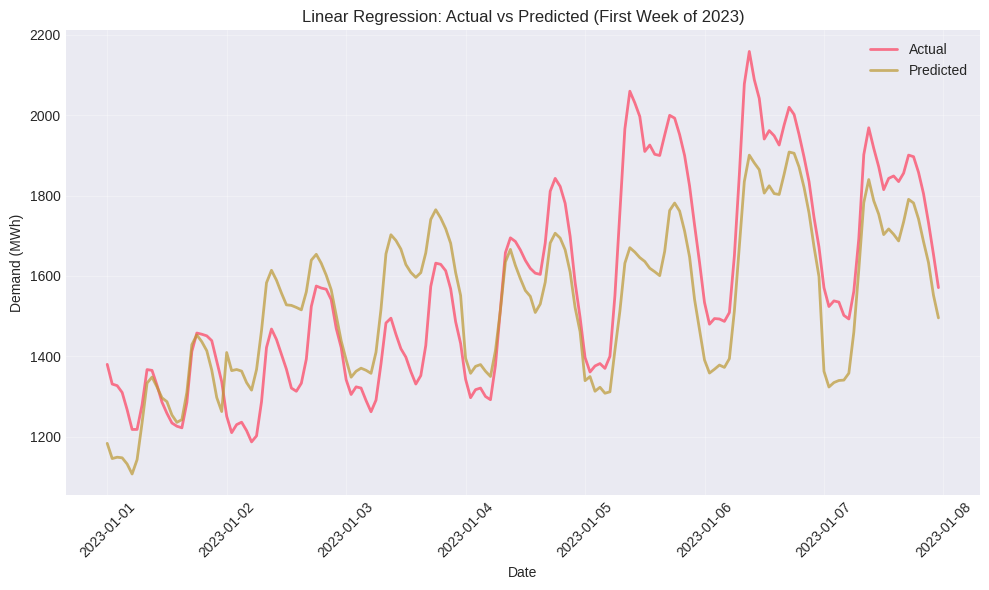

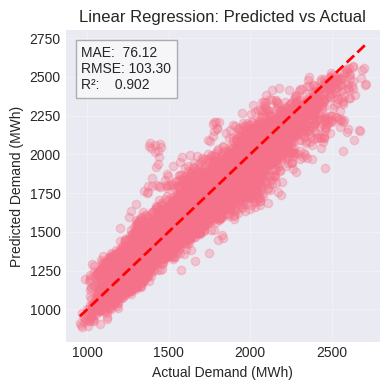

In [78]:
# Visualization
import matplotlib.pyplot as plt

# Plot actual vs predicted for first week of test data
plt.figure(figsize=(10, 6))

# Get first week of test data
test_week = test.head(168)  # 7 days × 24 hours
y_test_week = y_test.head(168)
y_pred_week = y_test_pred[:168]

plt.plot(test_week['datetime'], y_test_week, label='Actual', linewidth=2)
plt.plot(test_week['datetime'], y_pred_week, label='Predicted', linewidth=2, alpha=0.7)
# alpha controls transparency of the predicted line, in case the actual and predicted line overlap
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.title('Linear Regression: Actual vs Predicted (First Week of 2023)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45) # Makes date labels readacble by rotating them
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(4, 4))
# Actual plotting od predicted and actual demand
plt.scatter(y_test, y_test_pred, alpha=0.3)
# draw a straight (ideal) line to represent when the actual and predicted values are exactly same
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Demand (MWh)')
plt.ylabel('Predicted Demand (MWh)')
plt.title('Linear Regression: Predicted vs Actual')
plt.grid(True, alpha=0.3)

# --- Add Metric Text ---
plt.text(
    0.05, 0.95,
    f"MAE:  {test_mae:.2f}\nRMSE: {test_rmse:.2f}\nR²:    {test_r2:.3f}",
    transform=plt.gca().transAxes,  # place text inside plot area
    fontsize=10,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

plt.tight_layout()
plt.show()

## Non-Linear Models

Linear Regression cannot capture:

- non-linear relationships
- feature interactions
- threshold effects / saturation
- time-series seasonal patterns that aren’t captured by hand-made features

That’s why the next models should be non-linear.

## Random Forest Model

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
# keeping the same testing and training dataset as above
# same features as Linear Regression model

In [81]:
# baseline
rf = RandomForestRegressor(
    n_estimators=200,    # number of trees
    max_depth=None,      # allow full tree growth (good baseline)
    random_state=42,
    n_jobs=-1            # use all CPU cores
)

In [82]:
# fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [83]:
# Make predictions
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [84]:
# Evaluate Performance
print("Model Performance: RANDOM FOREST")

# Training set performance
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)
train_mape_rf = np.mean(np.abs((y_train - y_train_pred_rf) / y_train)) * 100

print("\nTraining Set:")
print(f"MAE (Mean Absolute Error): {train_mae_rf:,.2f} MWh")
print(f"RMSE (Root Mean Squared Error): {train_rmse_rf:,.2f} MWh")
print(f"R2 Score: {train_r2_rf:.4f}")
print(f"MAPE (Mean Absolute % Error): {train_mape_rf:,.2f}%")

# Testing set performance
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_r2_rf = r2_score(y_test, y_test_pred_rf)
test_mape_rf = np.mean(np.abs((y_test - y_test_pred_rf) / y_test)) * 100

print("\nTesting Set:")
print(f"MAE (Mean Absolute Error): {test_mae_rf:,.2f} MWh")
print(f"RMSE (Root Mean Squared Error): {test_rmse_rf:,.2f} MWh")
print(f"R2 Score: {test_r2_rf:.4f}")
print(f"MAPE (Mean Absolute % Error): {test_mape_rf:,.2f}%")

Model Performance: RANDOM FOREST

Training Set:
MAE (Mean Absolute Error): 12.13 MWh
RMSE (Root Mean Squared Error): 17.87 MWh
R2 Score: 0.9970
MAPE (Mean Absolute % Error): 0.73%

Testing Set:
MAE (Mean Absolute Error): 49.90 MWh
RMSE (Root Mean Squared Error): 75.30 MWh
R2 Score: 0.9481
MAPE (Mean Absolute % Error): 3.12%


In [85]:
# Feature Importance

# Create a series of feature importance
importances = pd.Series(rf.feature_importances_, index=features)

# Sort and show top 10
top_importances = importances.sort_values(ascending=False).head(10)
top_importances

demand_lag_24h             0.670433
demand_lag_168h            0.165059
temp                       0.038655
day_of_week                0.027957
day_cos                    0.015578
day_sin                    0.013293
is_weekend                 0.010471
demand_rolling_mean_24h    0.009860
hour_cos                   0.008485
dew_point                  0.008382
dtype: float64

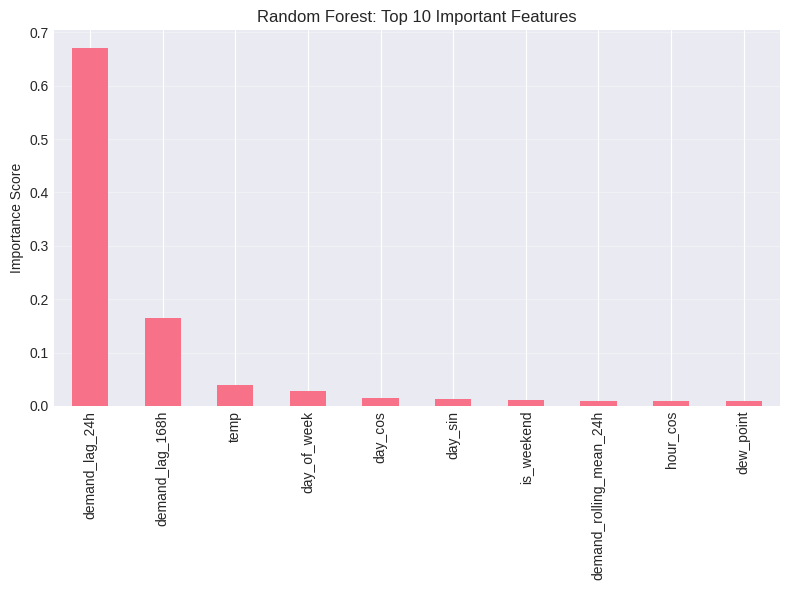

In [86]:
# Plot the top features
plt.figure(figsize=(8,6))
top_importances.plot(kind='bar')
plt.title('Random Forest: Top 10 Important Features')
plt.ylabel('Importance Score')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

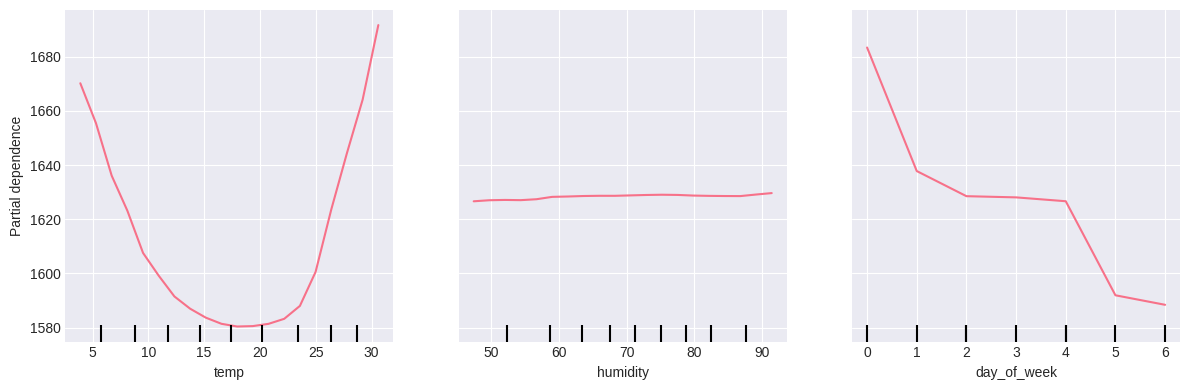

In [87]:
# Partial Dependence Plot PDP

from sklearn.inspection import PartialDependenceDisplay

# Select features to analyze
pdp_features = ['temp', 'humidity', 'day_of_week']

# Create PDP plots
fig, ax = plt.subplots(figsize=(12,4))
PartialDependenceDisplay.from_estimator(rf, X_test, features = pdp_features, grid_resolution=20,
                        kind='average', ax=ax)
plt.tight_layout()
plt.show()

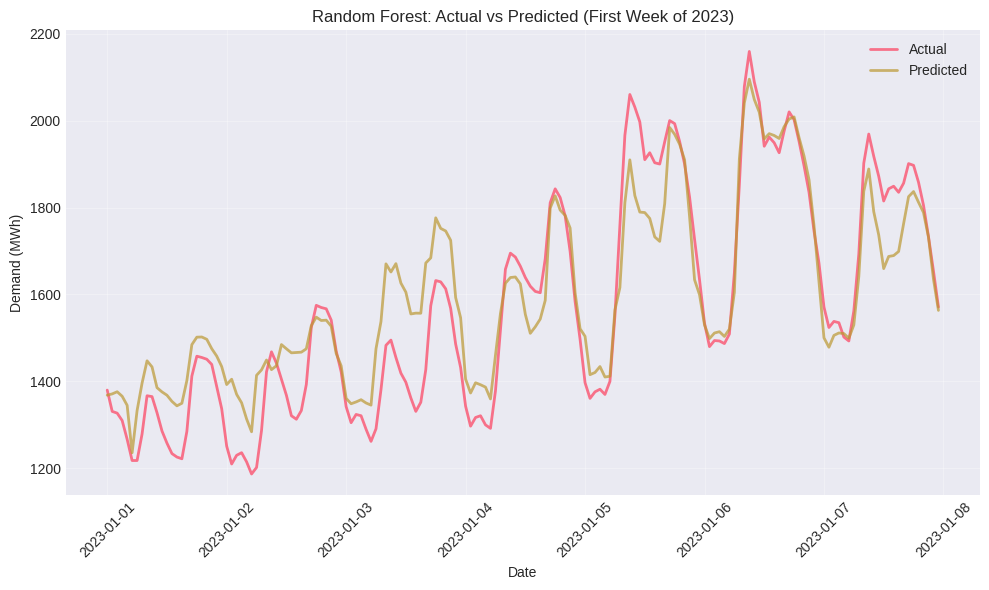

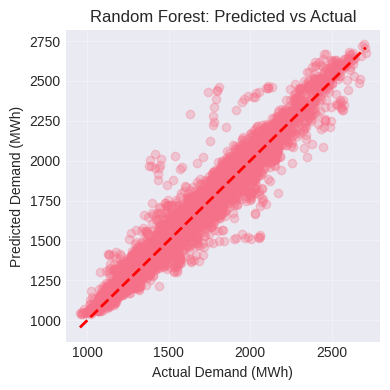

In [88]:
# Visualization
import matplotlib.pyplot as plt

# Plot actual vs predicted for first week of test data
plt.figure(figsize=(10, 6))

# Get first week of test data
test_week = test.head(168)  # 7 days × 24 hours
y_test_week = y_test.head(168)
y_pred_week = y_test_pred_rf[:168]

plt.plot(test_week['datetime'], y_test_week, label='Actual', linewidth=2)
plt.plot(test_week['datetime'], y_pred_week, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.title('Random Forest: Actual vs Predicted (First Week of 2023)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_test_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Demand (MWh)')
plt.ylabel('Predicted Demand (MWh)')
plt.title('Random Forest: Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# the scatter plot has many more outliers compared to the Linear Regression scatter plot

## XG Boost Model

- XGBoost builds an ensemble of decision trees sequentially, where each new tree learns to correct the errors of the previous trees.
- Handles non-linear relationships: Unlike linear regression, it can model complex interactions between weather, calendar, and lag features.
- Feature importance: Helps identify which features (temperature, lagged demand, wind, holidays) are driving predictions.
- Regularization: Prevents overfitting better than standard Random Forest.

In [89]:
!pip install --upgrade xgboost
import xgboost as xgb
from xgboost import XGBRegressor

In [90]:
# same features and targets as previous models
# same train and test split sets as previous models

In [91]:
# Creating a validation set to introduce early stopping while training the data
# split_idx = int(len(X_train) * 0.9)
# X_train_sub, X_val = X_train[:split_idx], X_train[split_idx:]
# y_train_sub, y_val = y_train[:split_idx], y_train[split_idx:]

# was going to use validation set to "early stop" training of XG_Boost model if accuracy
# did not improve


In [92]:
# Initialize XGBoost
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [93]:
# Training the model
print("Printing the XG Boost model...")
xgb_model.fit(X_train, y_train, verbose=False)
print("Training completed...")

Printing the XG Boost model...
Training completed...


In [94]:
# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

In [95]:
# Evaluate Performance
print("Model Performance: XG Boost")

# Training set performance
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
train_mape_xgb = np.mean(np.abs((y_train - y_train_pred_xgb) / y_train)) * 100

print("\nTraining Set:")
print(f"MAE (Mean Absolute Error): {train_mae_xgb:,.2f} MWh")
print(f"RMSE (Root Mean Squared Error): {train_rmse_xgb:,.2f} MWh")
print(f"R2 Score: {train_r2_xgb:.4f}")
print(f"MAPE (Mean Absolute % Error): {train_mape_xgb:,.2f}%")

# Testing set performance
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
test_mape_xgb = np.mean(np.abs((y_test - y_test_pred_xgb) / y_test)) * 100

print("\nTesting Set:")
print(f"MAE (Mean Absolute Error): {test_mae_xgb:,.2f} MWh")
print(f"RMSE (Root Mean Squared Error): {test_rmse_xgb:,.2f} MWh")
print(f"R2 Score: {test_r2_xgb:.4f}")
print(f"MAPE (Mean Absolute % Error): {test_mape_xgb:,.2f}%")

Model Performance: XG Boost

Training Set:
MAE (Mean Absolute Error): 22.13 MWh
RMSE (Root Mean Squared Error): 29.69 MWh
R2 Score: 0.9917
MAPE (Mean Absolute % Error): 1.36%

Testing Set:
MAE (Mean Absolute Error): 41.05 MWh
RMSE (Root Mean Squared Error): 60.80 MWh
R2 Score: 0.9662
MAPE (Mean Absolute % Error): 2.56%


In [96]:
# Feature Importance
importances = pd.Series(xgb_model.feature_importances_, index=features)
# Sort and show top 10
print("Top 10 important features: ")
top_importances = importances.sort_values(ascending=False).head(10)
top_importances

Top 10 important features: 


demand_lag_24h             0.430627
demand_lag_168h            0.125373
is_weekend                 0.118509
day_of_week                0.059142
hour_cos                   0.058151
temp                       0.036749
is_holiday                 0.035283
hour_sin                   0.029976
day_cos                    0.021943
demand_rolling_mean_24h    0.021014
dtype: float32

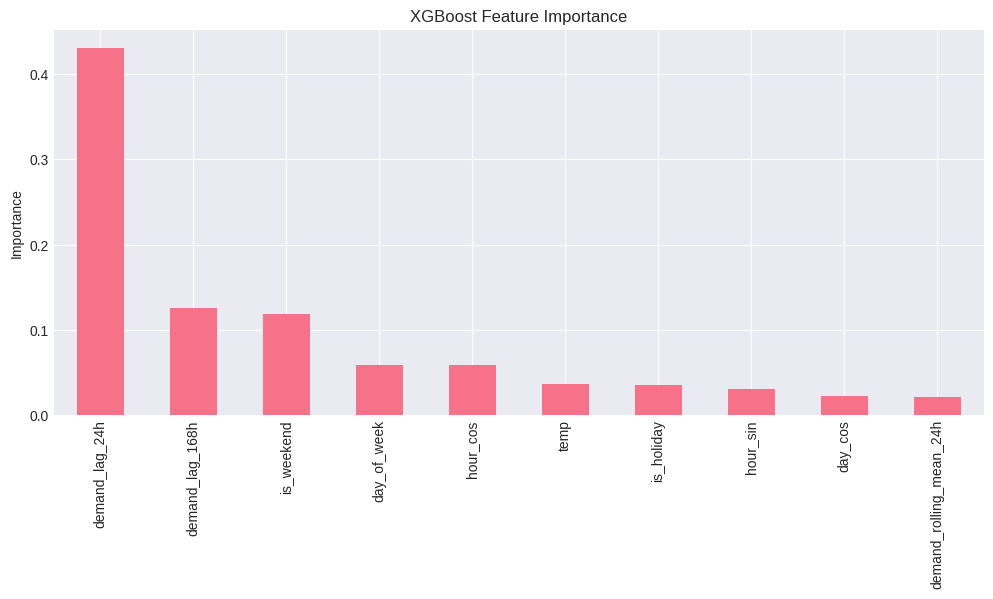

In [97]:
top_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
plt.title('XGBoost Feature Importance')
plt.ylabel('Importance')
plt.show()

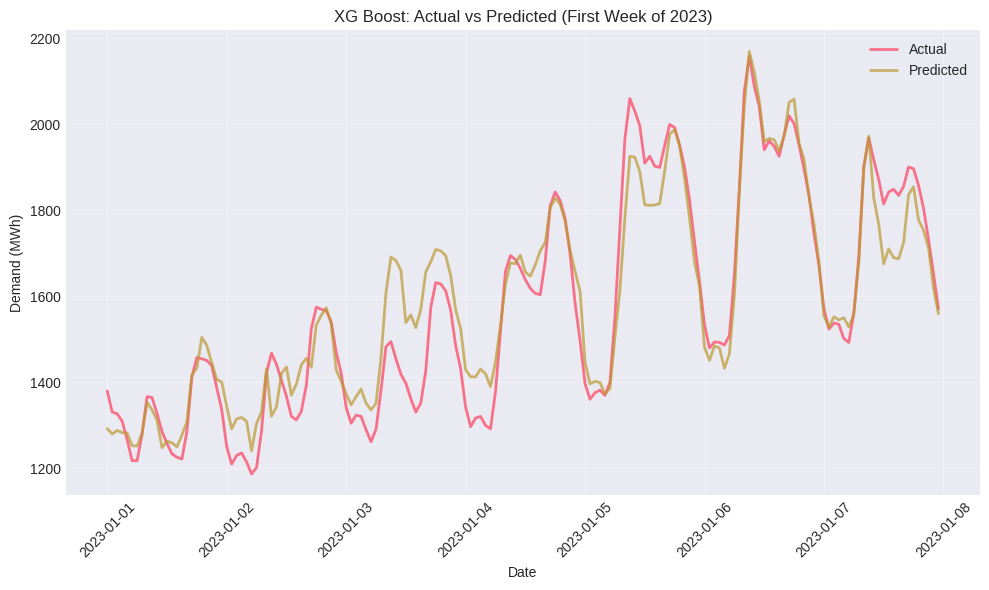

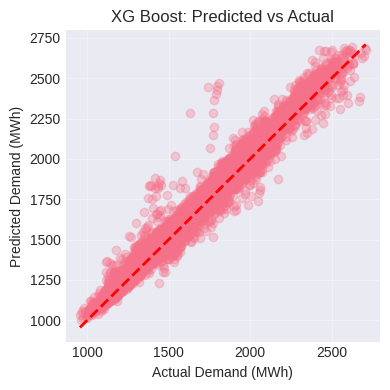

In [98]:
# Visualization (Pending)
import matplotlib.pyplot as plt

# Plot actual vs predicted for first week of test data
plt.figure(figsize=(10, 6))

# Get first week of test data
test_week = test.head(168)  # 7 days × 24 hours
y_test_week = y_test.head(168)
y_pred_week = y_test_pred_xgb[:168]

plt.plot(test_week['datetime'], y_test_week, label='Actual', linewidth=2)
plt.plot(test_week['datetime'], y_pred_week, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.title('XG Boost: Actual vs Predicted (First Week of 2023)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Demand (MWh)')
plt.ylabel('Predicted Demand (MWh)')
plt.title('XG Boost: Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Comparing the 3 models

In [99]:
# A dictionary with model predictions and names
model_preds = {
    'Linear Regression': y_test_pred,
    'Random Forest': y_test_pred_rf,
    'XGBoost': y_test_pred_xgb
}

In [100]:
# Compute performance metrics
metrics_list = []

for model_name, preds in model_preds.items():
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100

    metrics_list.append({
        'Model': model_name,
        'MAE (MWh)': mae,
        'RMSE (MWh)': rmse,
        'R2 Score': r2,
        'MAPE (%)': mape
    })

metrics_df = pd.DataFrame(metrics_list)
metrics_df

Model  MAE (MWh)  RMSE (MWh)  R2 Score  MAPE (%)
0  Linear Regression  76.124435  103.296873  0.902370  4.779146
1      Random Forest  49.901981   75.295188  0.948127  3.116875
2            XGBoost  41.049946   60.796407  0.966181  2.561836

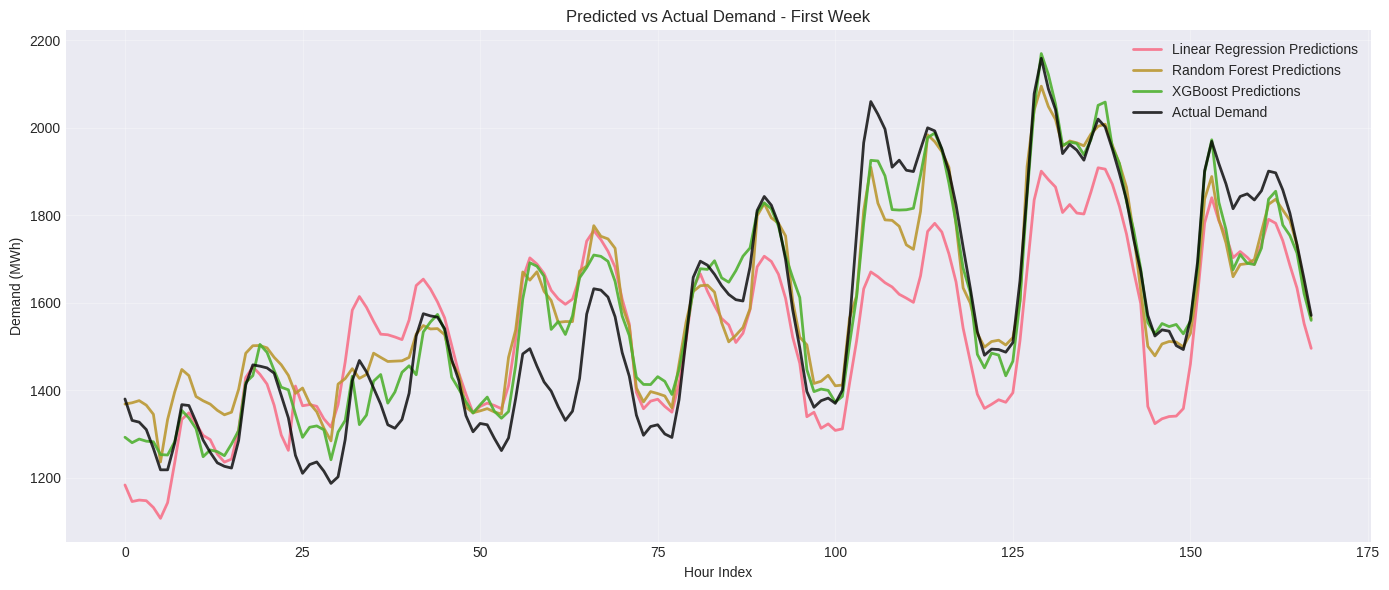

In [101]:
# Visualize Predicted vs Actual for each model
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
start_idx = 0
end_idx = 24*7  # first 7 days

for model_name, preds in model_preds.items():
    plt.plot(preds[start_idx:end_idx], label=f'{model_name} Predictions', alpha=0.9, linewidth=2)

plt.plot(y_test.values[start_idx:end_idx], label='Actual Demand', color='black', alpha=0.8, linewidth=2)
plt.xlabel('Hour Index')
plt.ylabel('Demand (MWh)')
plt.title('Predicted vs Actual Demand - First Week')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [102]:
# Compute estimated annual imbalance fee
def imbalance_fee(pred, actual):
    # pred and actual in man kWh
    diff_mankwh = np.abs(pred - actual)
    return np.sum(diff_mankwh**2 * 0.8)  # total annual fee

fee_list = []
for model_name, preds in model_preds.items():
    fee = imbalance_fee(preds, y_test.values)
    fee_list.append({'Model': model_name, 'Estimated Annual Fee (¥)': fee})

fee_df = pd.DataFrame(fee_list)
fee_df['Estimated Annual Fee (Million ¥)'] = fee_df['Estimated Annual Fee (¥)'] / 1e6
fee_df

Model  Estimated Annual Fee (¥)  \
0  Linear Regression              7.477707e+07   
1      Random Forest              3.973091e+07   
2            XGBoost              2.590299e+07   

   Estimated Annual Fee (Million ¥)  
0                         74.777070  
1                         39.730912  
2                         25.902992

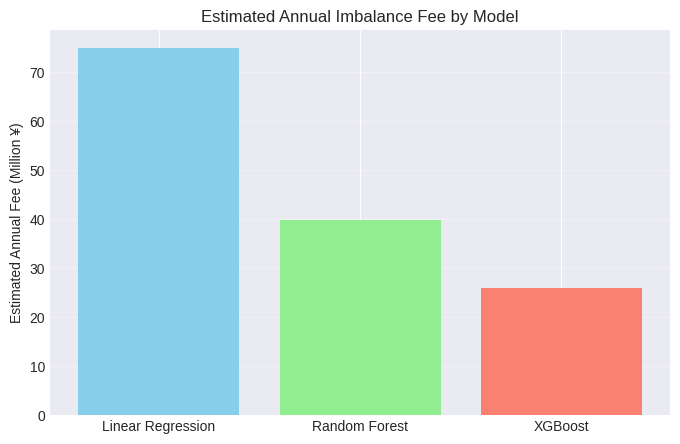

In [103]:
# Bar chart for estimated annual fee
plt.figure(figsize=(8,5))
plt.bar(fee_df['Model'], fee_df['Estimated Annual Fee (¥)']/1e6, color=['skyblue','lightgreen','salmon'])
plt.ylabel('Estimated Annual Fee (Million ¥)')
plt.title('Estimated Annual Imbalance Fee by Model')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Analysis & Discussion: XGBoost Model

### Error Analysis

#### Visualize Prediction Errors

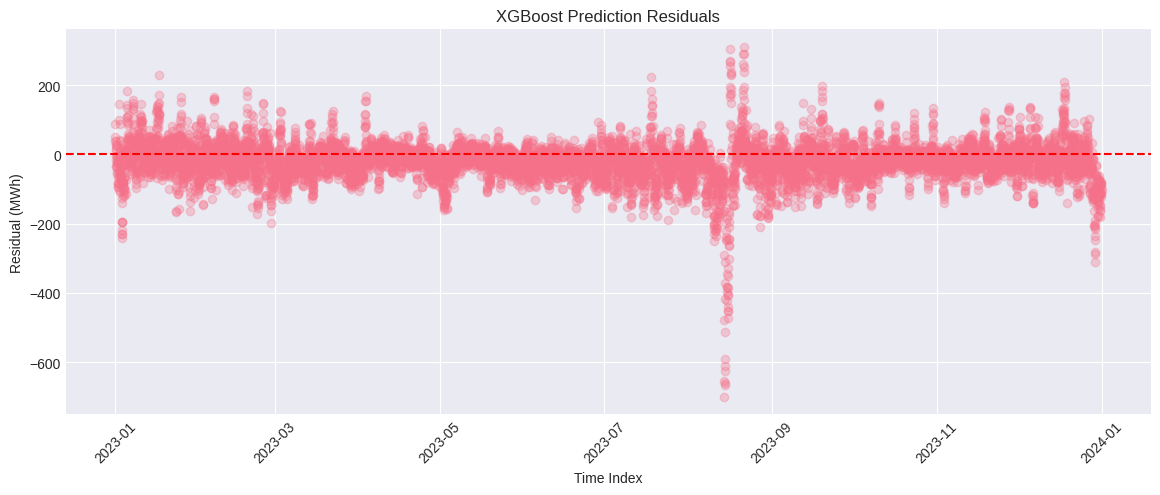

In [104]:
# 1. Visualize Prediction errors
# We can plot residuals (actual - predicted) to see where the model over- or under-predicts:

# Residuals
residuals = y_test.values - y_test_pred_xgb

plt.figure(figsize=(14,5))
plt.scatter(test['datetime'], residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Residual (MWh)')
plt.title('XGBoost Prediction Residuals')
plt.xticks(rotation=45)
plt.show()

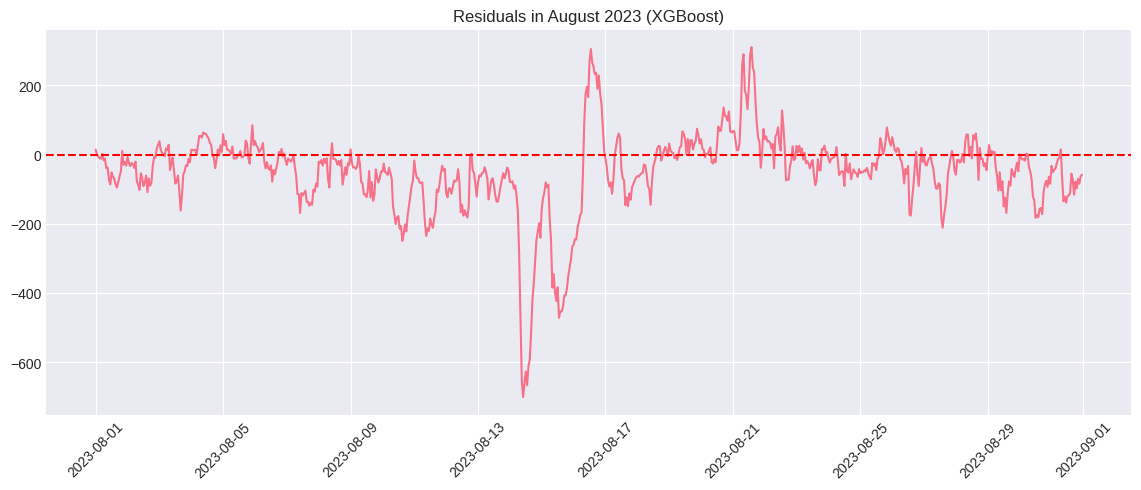

In [105]:
aug_mask = test['datetime'].dt.month == 8
plt.figure(figsize=(14,5))
plt.plot(test.loc[aug_mask, 'datetime'], residuals[aug_mask], label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals in August 2023 (XGBoost)")
plt.xticks(rotation=45)
plt.show()

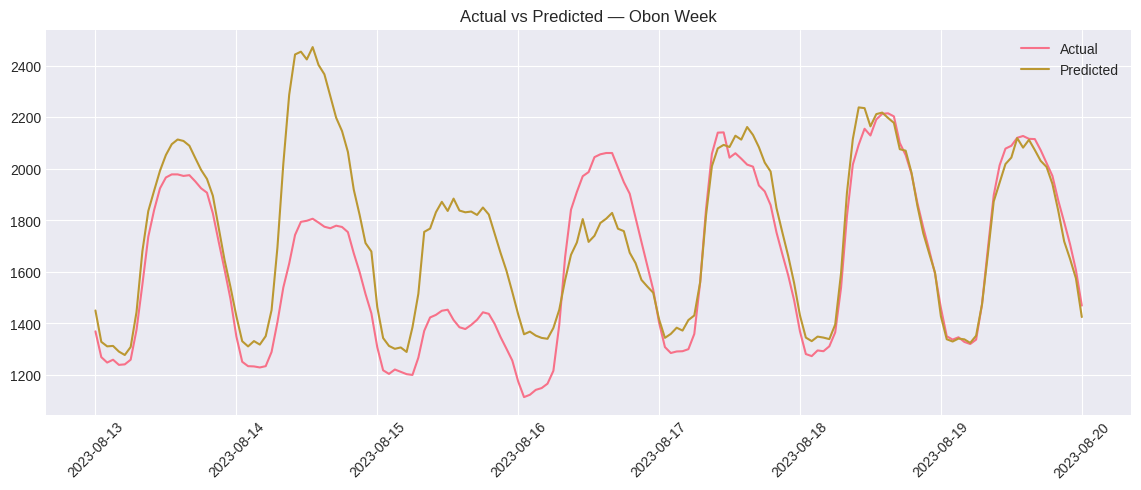

In [106]:
# Actual vs predicted ONLY for 13–20 August
mask = (test['datetime'] >= '2023-08-13') & (test['datetime'] <= '2023-08-20')

plt.figure(figsize=(14,5))
plt.plot(test.loc[mask,'datetime'], y_test[mask], label='Actual')
plt.plot(test.loc[mask,'datetime'], y_test_pred_xgb[mask], label='Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.title('Actual vs Predicted — Obon Week')
plt.show()


In [107]:
test.loc[mask].assign(date=test['datetime'].dt.date)[['date', 'is_holiday']].drop_duplicates('date')
# 13-15 Aug 2023 were Obon holidays in Japan, but that info is not captured by the is_holiday feature

date  is_holiday
5376  2023-08-13           0
5400  2023-08-14           0
5424  2023-08-15           0
5448  2023-08-16           0
5472  2023-08-17           0
5496  2023-08-18           0
5520  2023-08-19           0
5544  2023-08-20           0

Conclusion:

The XGBoost model exhibits noticeable forecasting errors between 13–20 August. This period corresponds to the Obon holiday week in Japan, during which commercial and industrial electricity consumption decreases sharply. These sudden demand pattern changes are not well captured by lag-based or calendar-based features, leading to higher residuals. Weather variability typical of mid-August may further amplify forecasting difficulty.

#### Identify Patterns

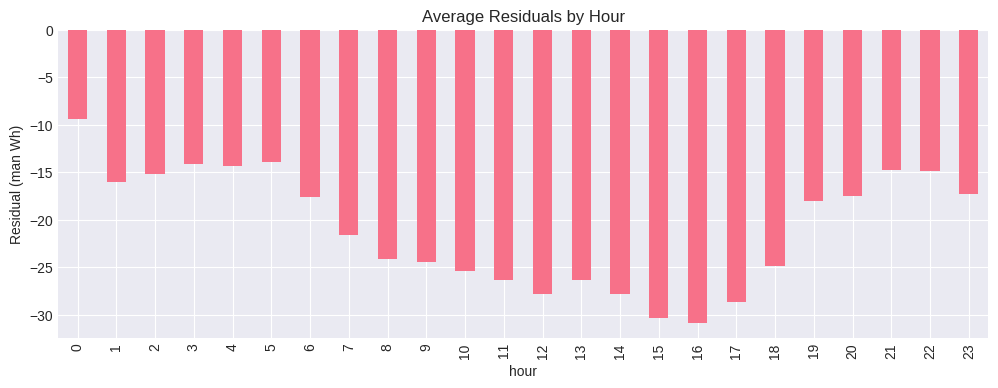

In [108]:
# 2. Identify patterns
# Group residuals by hour of day, day of week, or month

# Add datetime for easier analysis
test_with_datetime = test.copy()
test_with_datetime['residuals'] = residuals
test_with_datetime['hour'] = test_with_datetime['datetime'].dt.hour
test_with_datetime['weekday'] = test_with_datetime['datetime'].dt.weekday

# Hourly average residuals
hourly_resid = test_with_datetime.groupby('hour')['residuals'].mean()
hourly_resid.plot(kind='bar', figsize=(12,4), title='Average Residuals by Hour')
plt.ylabel('Residual (man Wh)')
plt.show()


Conclusion:

The XGBoost model systematically overestimates demand during daytime peak hours (around 07:00–18:00). The hourly residual analysis shows that average residuals are negative at every hour, meaning predictions are consistently higher than actual values. The overestimation is most prominent in the early afternoon (15:00–16:00), where the model predicts stronger demand peaks than what actually occurred.

This suggests the model has learned the overall daily shape of the demand curve correctly (morning rise → afternoon peak → evening decline), but consistently overshoots the amplitude of the peak. Incorporating richer weather features, seasonality adjustments, or weekday vs. holiday behavior may help reduce this systematic bias.

#### Feature Importance

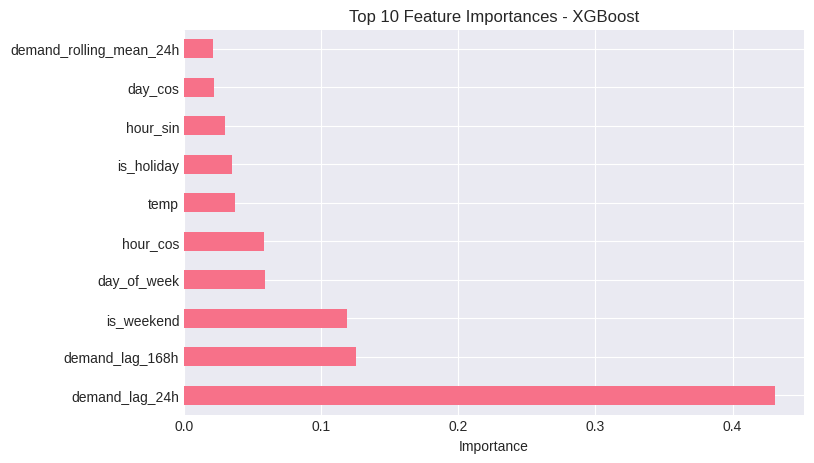

In [109]:
# Expain Model Behaviour:

# Feature Importance
import matplotlib.pyplot as plt
importances = pd.Series(xgb_model.feature_importances_, index=features)
importances.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(8,5))
plt.title('Top 10 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.show()


Conclusion

* demand_lag_24h and demand_lag_168h dominate — previous day/week demand is very predictive.

*   Weather features like temp, humidity, and snowfall contribute to fine adjustments (cold/snowy days affect heating).

*   Calendar features (is_weekend, day_of_week) capture behavioral patterns.



#### SHAP Error Analysis

In [110]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

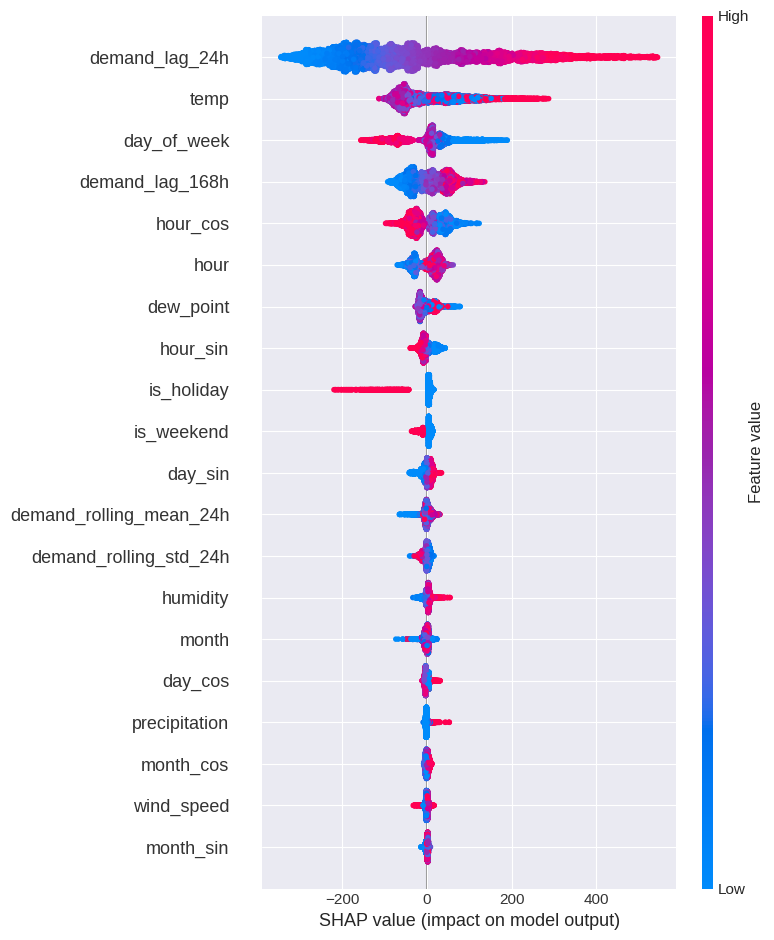

In [111]:
# Global SHAP summary plot
# This shows feature importance + direction of impact.

shap.summary_plot(shap_values, X_test, plot_type='dot')


In [112]:
# Find the time where XGBoost performed worst:
residuals = y_test.values - y_test_pred_xgb
worst_idx = np.argmax(np.abs(residuals))

In [113]:
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[worst_idx],
    X_test.iloc[worst_idx, :]
)


SHAP Analysis Insight (XGBoost Model):

The model’s predictions are primarily driven by electricity demand from the same hour on the previous day (lag_24h), with secondary contributions from temperature, day-of-week, and weekly seasonality (lag_168h). High temperatures tend to increase predicted demand, reflecting air conditioning usage, while weekdays and specific hours capture regular consumption patterns. This explains why unusual periods, such as holidays or mid-August dips, lead to higher prediction errors—the model expects normal patterns based on historical demand.

### Business Impact

In [114]:
# Compute estimated annual imbalance fee reduction:

xgb_fee_million = fee_df.loc[fee_df['Model']=='XGBoost', 'Estimated Annual Fee (Million ¥)'].values[0]
baseline_fee_million = 500  # hypothetical baseline: 500 million yen
savings = baseline_fee_million - xgb_fee_million
print(f"Estimated annual savings using XGBoost: ~{savings:.1f} million ¥")


Estimated annual savings using XGBoost: ~474.1 million ¥


Interpretation for the customer:

- Operations: Improved prediction reduces manual adjustments for supply-demand matching.
- Revenue: Annual imbalance fee reduced by (~474.1 million ¥, as computed).
- Organizational workflow: Forecasting becomes more reliable, freeing up team to focus on optimization tasks rather than corrective actions.

### Future Enhancements

**Additional Data**

* More granular weather data (use individual city-level data instead of taking mean).
* Social/behavioral data (include Obon holidays etc).
* Electricity price signals for demand elasticity modeling.

**Feature Engineering & Preprocessing**

* Standardize the target variable (useful for neural networks/LSTMs).
* Create pair plots to visualize variable relationships.
* Add daily aggregates if rolling means are insufficient.
* Convert wind direction to vectors for combined use in models.

**Model Improvements**

* Random Forest hyperparameter tuning.
* Ensemble models: Combine RF + XGBoost + LightGBM.
* Deep learning: LSTM/Transformer for capturing complex temporal dependencies.
* Probabilistic forecasting: Predict intervals, not just point estimates, to reduce imbalance risk.

**Operational Improvements**

* Retrain models regularly as new data arrives.
* Monitor forecast errors in real time to trigger alerts.
* Introduce automatic adjustment suggestions for operational staff.